In [1]:
import sys

from pathlib import Path

sys.path.append(str(Path().absolute().parent))
import time

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Dict

import ee
import geemap

ee.Initialize(project="thurgau-irrigation")

from utils.ee_utils import (
    back_to_float,
    back_to_int,
)

---

## Utility functions

In [3]:
def filter_df_by_ids(df: pd.DataFrame, ids: List[str]) -> pd.DataFrame:
    return df[df["ID"].isin(ids)]

## Validation Data:

In [4]:
path_to_validation = (
    "/Users/cooper/Desktop/irrigation-mapper/data/HAFL_irri_Nov22_DataIrri.csv"
)


def get_validation_irrigation_data(path_to_validation: str) -> pd.DataFrame:
    validation_raw = pd.read_csv(path_to_validation, sep=";", encoding="utf-8")

    column_mapping = {"Jahr": "Year", "Datum": "Date", "iri_val_mm": "Irrigation_[mm]"}

    validation_raw = validation_raw.rename(columns=column_mapping)

    return validation_raw

In [5]:
validation_irrigation = get_validation_irrigation_data(path_to_validation)


field_with_no_data = ["18-1-510419", "20-1-511772", "20-1-863291", "19-1-510472"]

irrigated_fields_ids = [
    id for id in validation_irrigation["ID"].unique() if id not in field_with_no_data
]

## Getting the model estimations:

In [6]:
def get_broye_fields(year: int, options: Dict) -> ee.FeatureCollection:

    version = options["version"]
    et_product = options["et_product"]
    etc_threshold = options["etc_threshold"]
    min_irr_threshold = options["min_irr_threshold"]

    collection_path = f"projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_per_field_{version}/ET_blue_per_field_{year}_dekadal_from_{et_product}_ETC_{etc_threshold}_PRC50_min_irr_{min_irr_threshold}"
    feature_collection = ee.FeatureCollection(collection_path)

    return feature_collection


def filter_collection_by_year(
    collection: ee.FeatureCollection, year: int
) -> ee.FeatureCollection:
    # Convert year to 2-digit string format
    year_prefix = str(year)[2:]

    # Filter collection based on ID prefix
    filtered = collection.filter(ee.Filter.stringStartsWith("ID", year_prefix))

    return filtered

In [7]:
options = {
    "version": "v4",
    "et_product": "WaPOR_10m",
    "etc_threshold": 90,
    "min_irr_threshold": 100,
}

field_dict = {}
for year in range(2018, 2022):
    fields = get_broye_fields(year, options)
    fields = filter_collection_by_year(fields, year)

    field_dict[year] = fields

In [8]:
def get_unique_ids(feature_collection: ee.FeatureCollection) -> List[str]:
    return list(feature_collection.aggregate_array("ID").distinct().getInfo())


non_irrigated_fields_ids = []

for year in range(2018, 2022):
    unique_ids = get_unique_ids(field_dict[year])
    non_irrigated_fields_ids += [
        id
        for id in unique_ids
        if id not in irrigated_fields_ids and id not in field_with_no_data
    ]

non_irrigated_fields_ids

['18-1-510444',
 '18-1-510470',
 '18-1-863297',
 '18-1-510414',
 '18-1-863314',
 '18-1-863291',
 '18-1-510460',
 '18-1-510473',
 '19-1-512197',
 '19-2-511783',
 '19-2-511819',
 '19-1-512267',
 '19-1-510470',
 '19-1-510444',
 '19-1-510414',
 '19-1-863297',
 '19-1-863291',
 '19-1-511809',
 '19-1-510473',
 '19-1-510460',
 '19-1-511777',
 '19-1-510408',
 '19-1-859055',
 '19-1-510419',
 '19-1-511772',
 '19-1-512100',
 '19-1-863314',
 '19-1-510418',
 '19-1-853816',
 '20-1-510465',
 '20-1-512197',
 '20-1-863297',
 '20-1-863314',
 '20-1-511809',
 '20-1-510460',
 '20-1-513720',
 '20-1-511777',
 '20-1-510473',
 '20-1-510458',
 '20-1-510408',
 '20-1-512267',
 '20-1-512100',
 '20-1-510414',
 '20-1-513719',
 '20-1-853937',
 '20-1-510470',
 '20-1-513609',
 '20-1-863293',
 '20-1-510419',
 '20-1-510467',
 '20-1-510444',
 '20-1-513606',
 '20-1-510430',
 '21-1-510459',
 '21-1-513726',
 '21-1-510408',
 '21-1-510419',
 '21-1-510471',
 '21-1-863297',
 '21-1-863291',
 '21-1-863314',
 '21-1-510434',
 '21-1-5

In [9]:
def get_fields_by_id(
    feature_collection: ee.FeatureCollection, ids: List[str]
) -> ee.FeatureCollection:
    return feature_collection.filter(ee.Filter.inList("ID", ids))

## Soil Mositure Data:

In [10]:
irrigation_threshold_data_path = (
    "/Users/cooper/Desktop/irrigation-mapper/data/SoilMoistureData/DataMeta_hsol.csv"
)

def get_irrigation_threshold_data(irrigation_threshold_data_path) -> pd.DataFrame:
    """
    Get the data meta information
    """
    irrigation_threshold_data = pd.read_csv(irrigation_threshold_data_path, sep=";", encoding="utf-8")

    column_mapping = {
        "Zuordnungscode": "ID",
        "Jahr": "Year",
        "Feldkapazitaet": "FieldCapacity",
        "Bewaesserungsschwelle": "IrrigationThreshold",
    }

    irrigation_threshold_data = irrigation_threshold_data.rename(columns=column_mapping)

    columns_to_return = [
        "ID",
        "Year",
        "FieldCapacity",
        "IrrigationThreshold",
    ]

    return irrigation_threshold_data[columns_to_return]


irrigation_threshold_data = get_irrigation_threshold_data(irrigation_threshold_data_path)
irrigation_threshold_data

ID  Year  FieldCapacity  IrrigationThreshold
0    18-1-510414    18            125                 87.5
1    18-1-510420    18            170                119.0
2    18-1-510429    18            143                100.1
3    18-1-510432    18            140                 98.0
4    18-1-510444    18            140                 98.0
..           ...   ...            ...                  ...
105  21-1-513719    21            168                117.6
106  21-1-513720    21            157                109.9
107  21-1-863291    21            164                114.8
108  21-1-863297    21            144                100.8
109  21-1-863314    21            165                115.5

[110 rows x 4 columns]

In [11]:
soil_moisture_data_path = "/Users/cooper/Desktop/irrigation-mapper/data/SoilMoistureData/DataSondenMesures_hsol.csv"

def get_soil_moisture_measurements(soil_moisture_data_path: str) -> pd.DataFrame:
    """
    Get the soil moisture measurements
    """

    soil_moisture_data = pd.read_csv(soil_moisture_data_path, sep=";", encoding="utf-8")

    soil_moisture_data["Datum"] = pd.to_datetime(
        soil_moisture_data["Datum"], dayfirst=True
    )

    column_mapping = {"Datum": "Date", "intSumRac": "TotalSoilMoisture_RootZone"}

    soil_moisture_data = soil_moisture_data.rename(columns=column_mapping)

    columns_to_return = ["ID", "Date", "TotalSoilMoisture_RootZone"]

    return soil_moisture_data[columns_to_return]


soil_moisture_data = get_soil_moisture_measurements(soil_moisture_data_path)
# soil_moisture_data = filter_df_by_ids(soil_moisture_data, irrigated_fields_ids)


### Plotting the soil moisture time series and comparing to the "Grober Richtwert zur Interpretation"

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


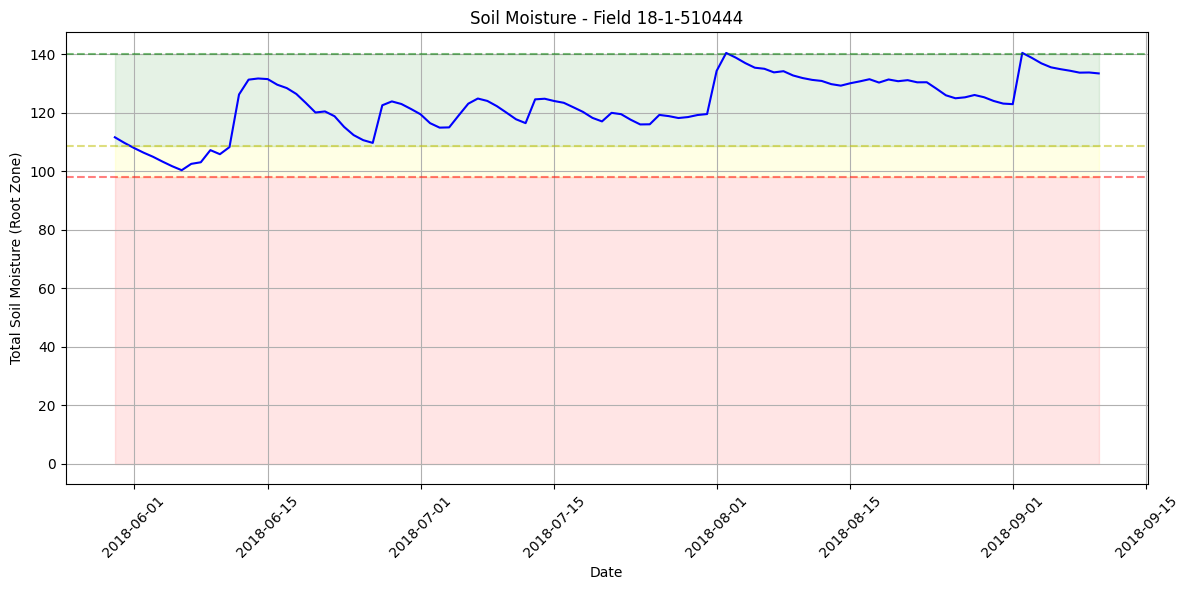

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


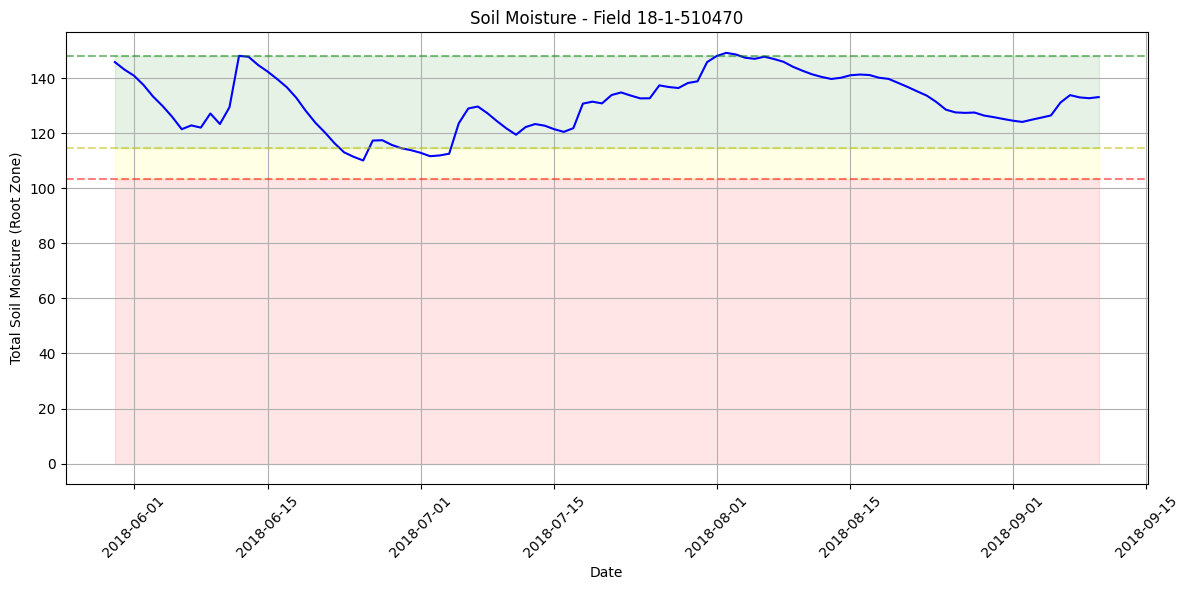

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


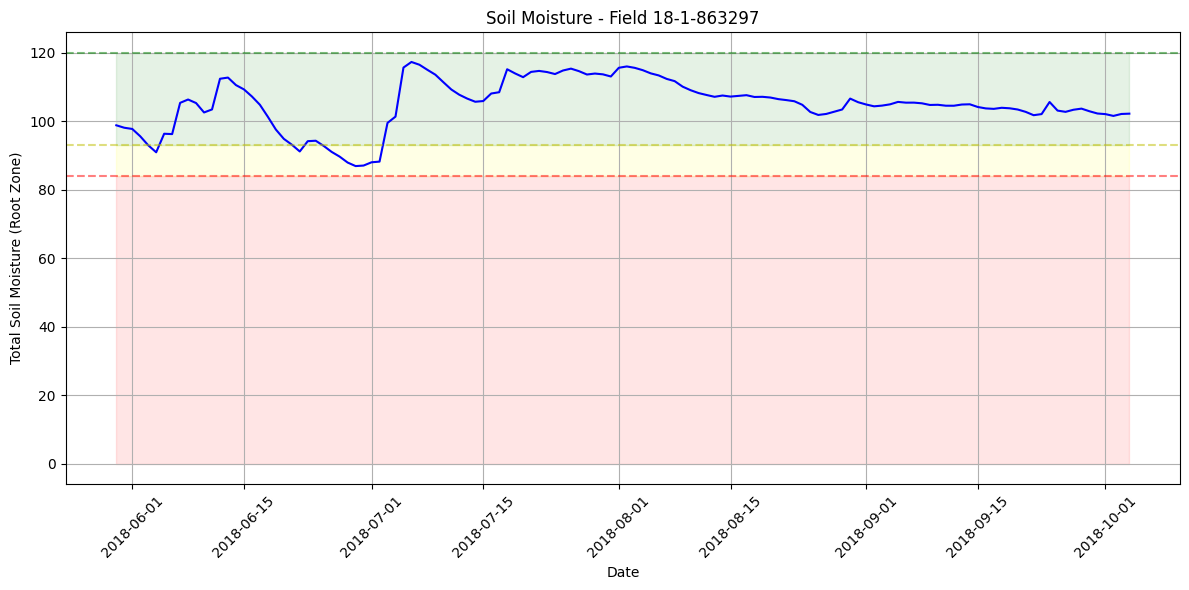

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


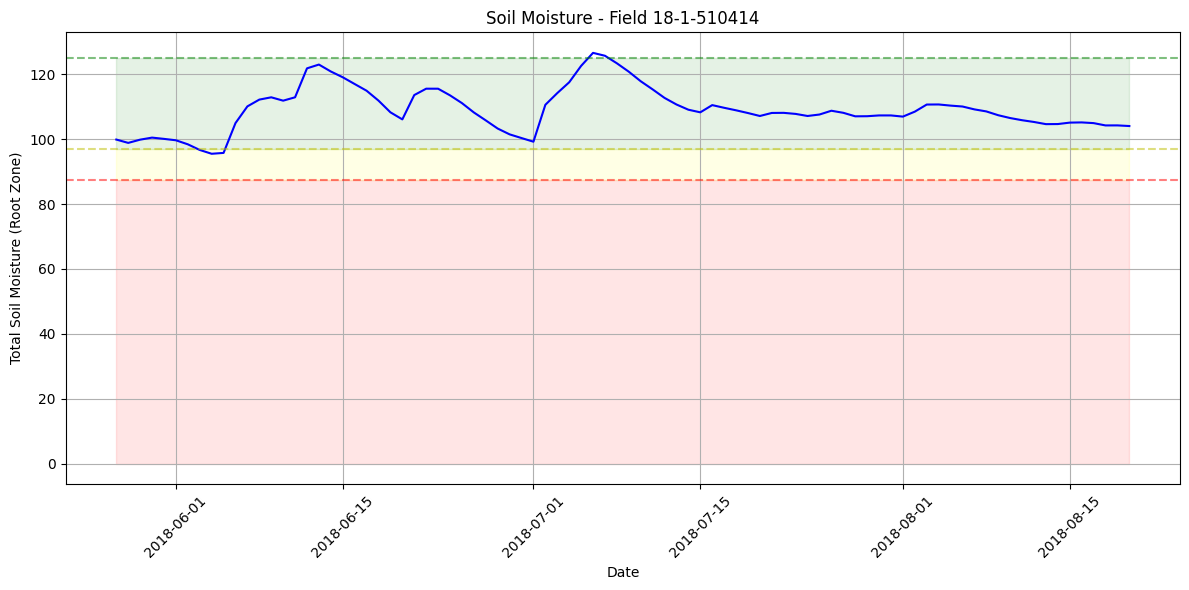

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


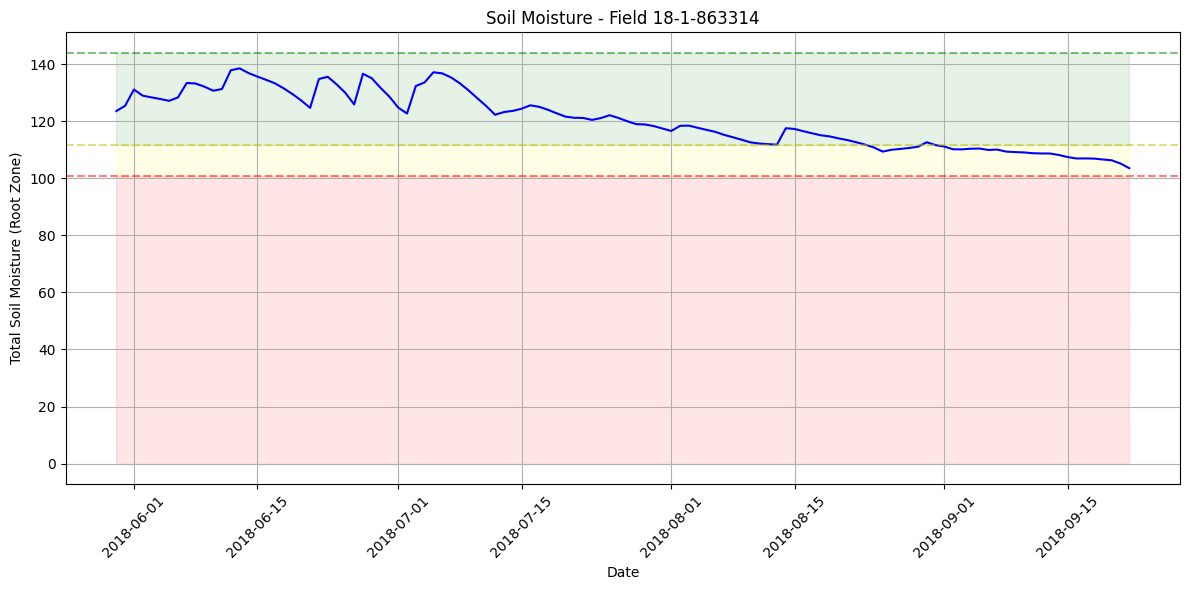

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


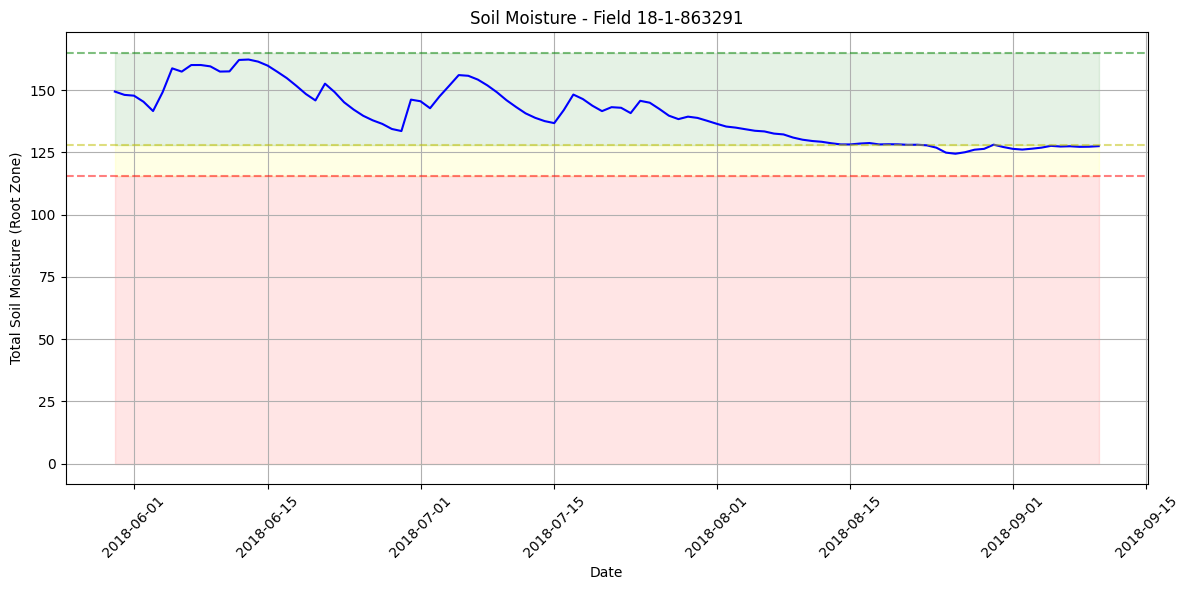

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


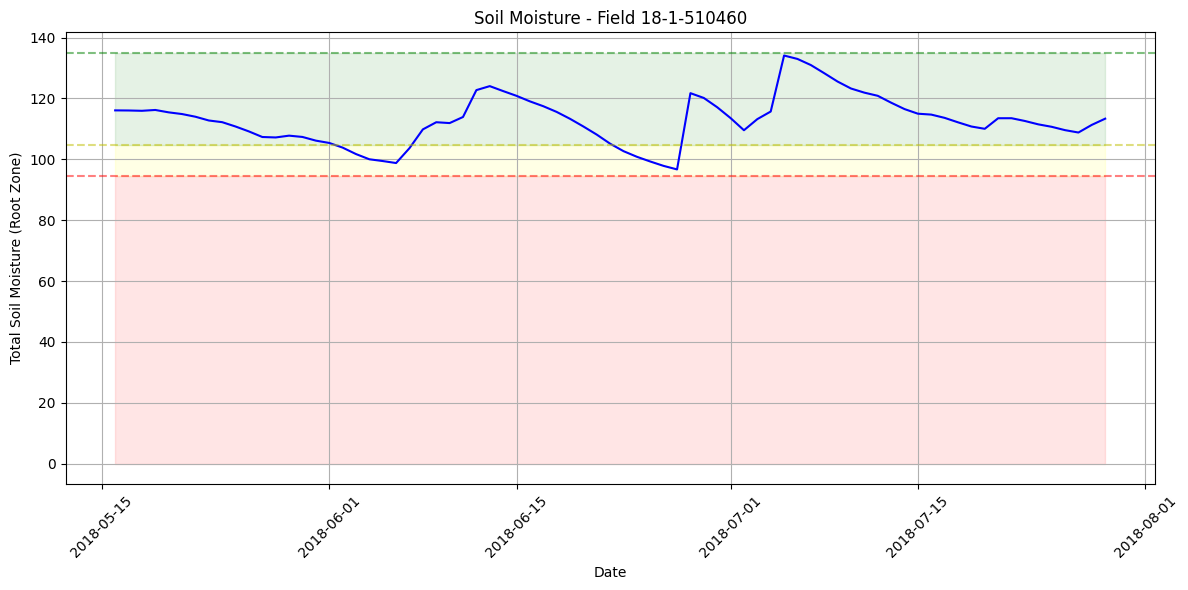

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


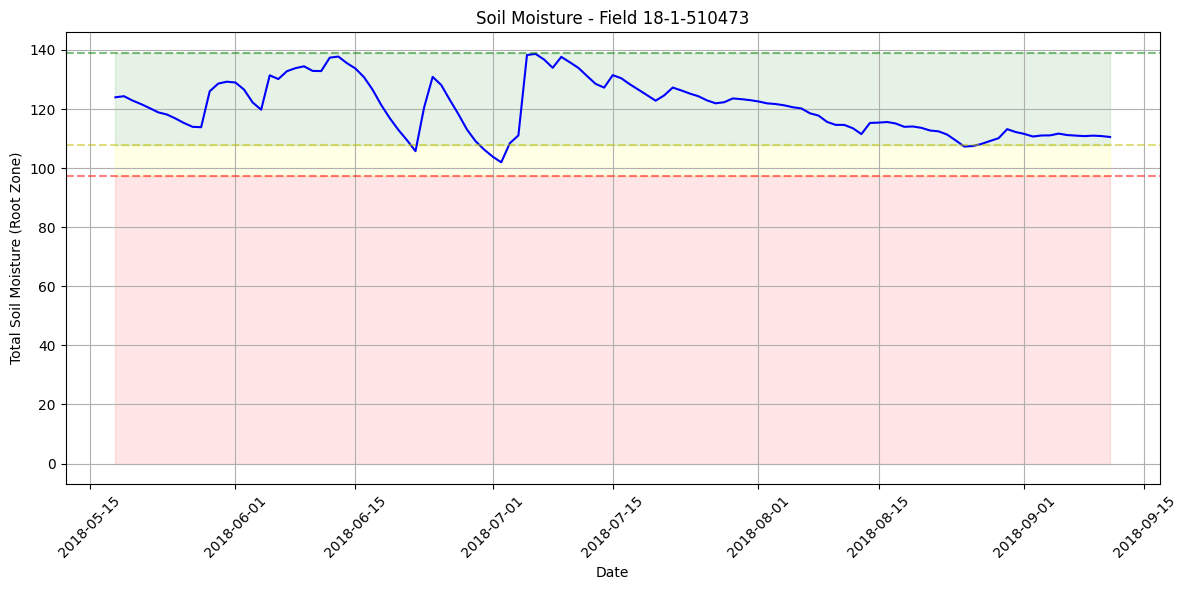

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


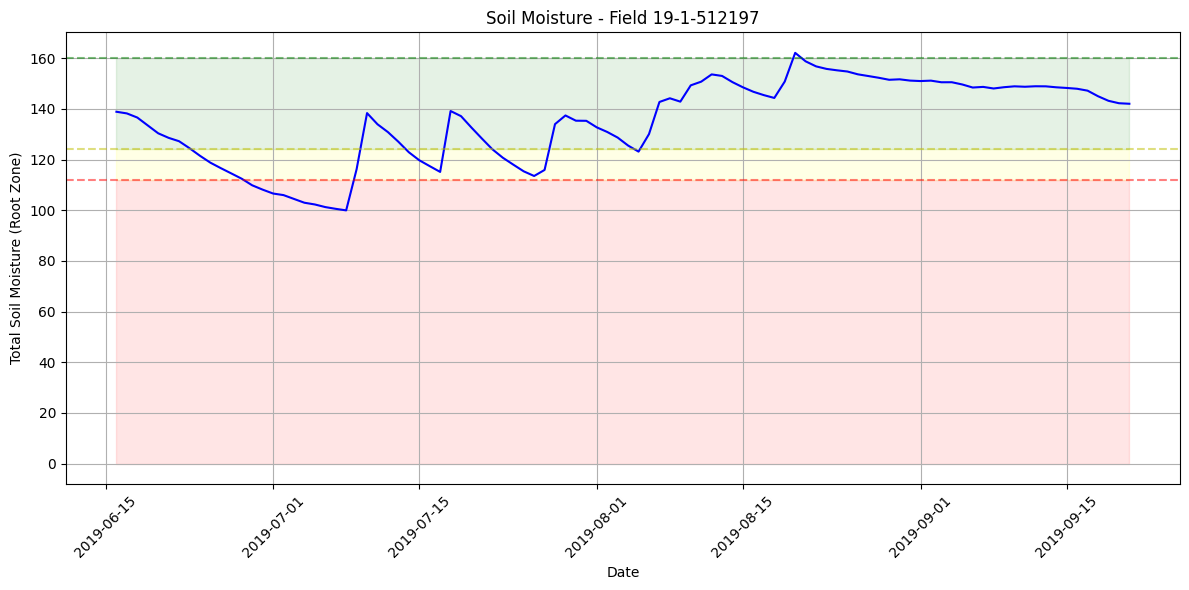

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


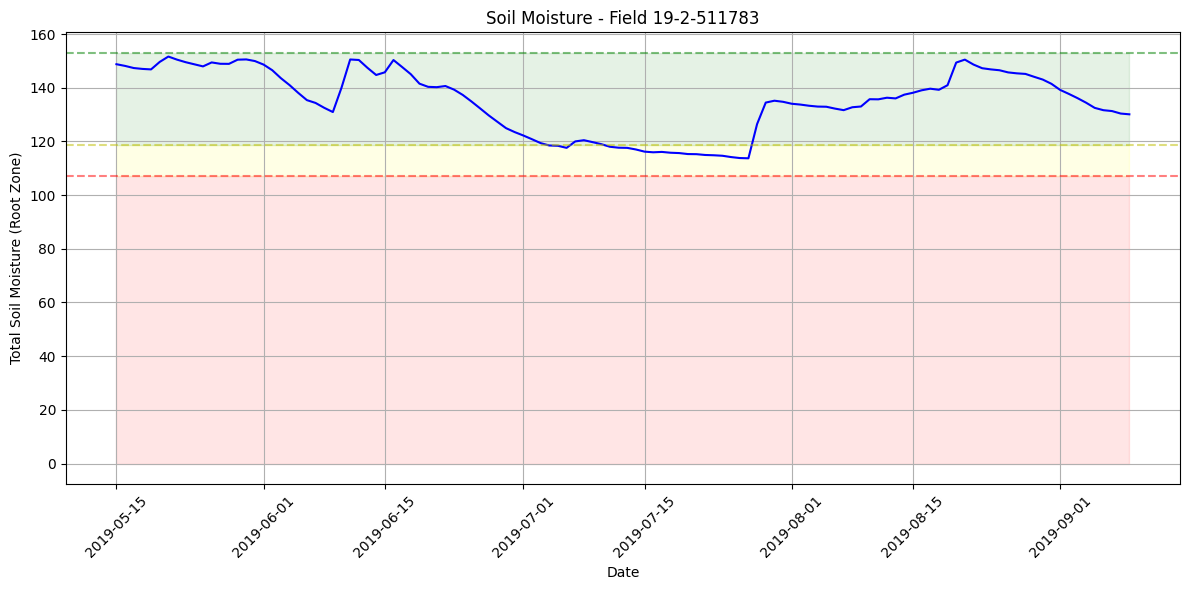

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


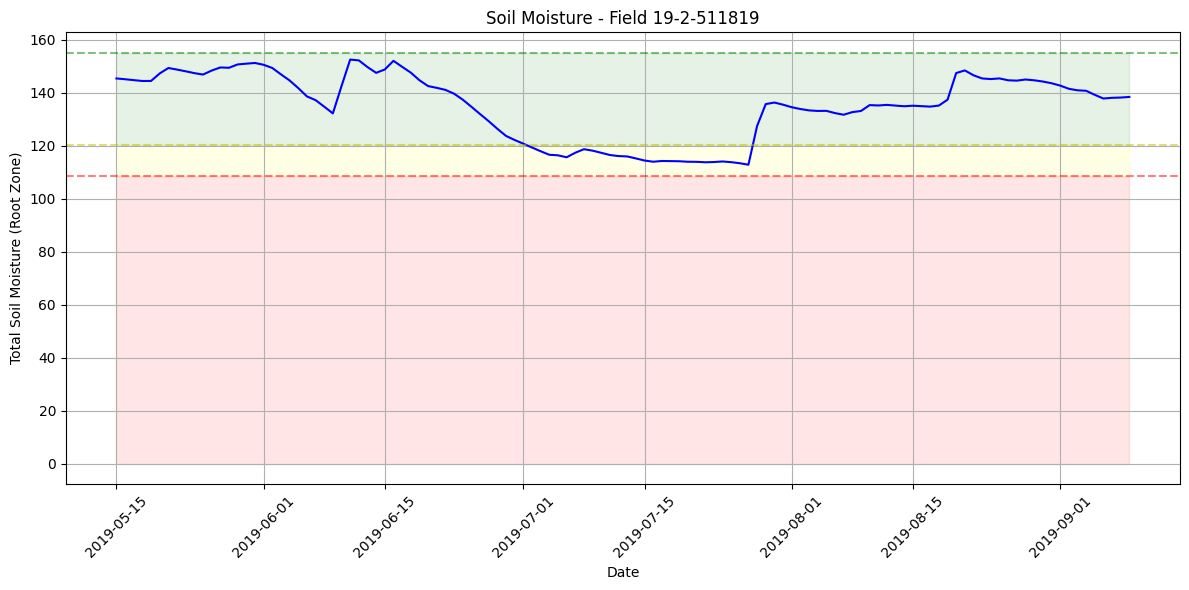

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


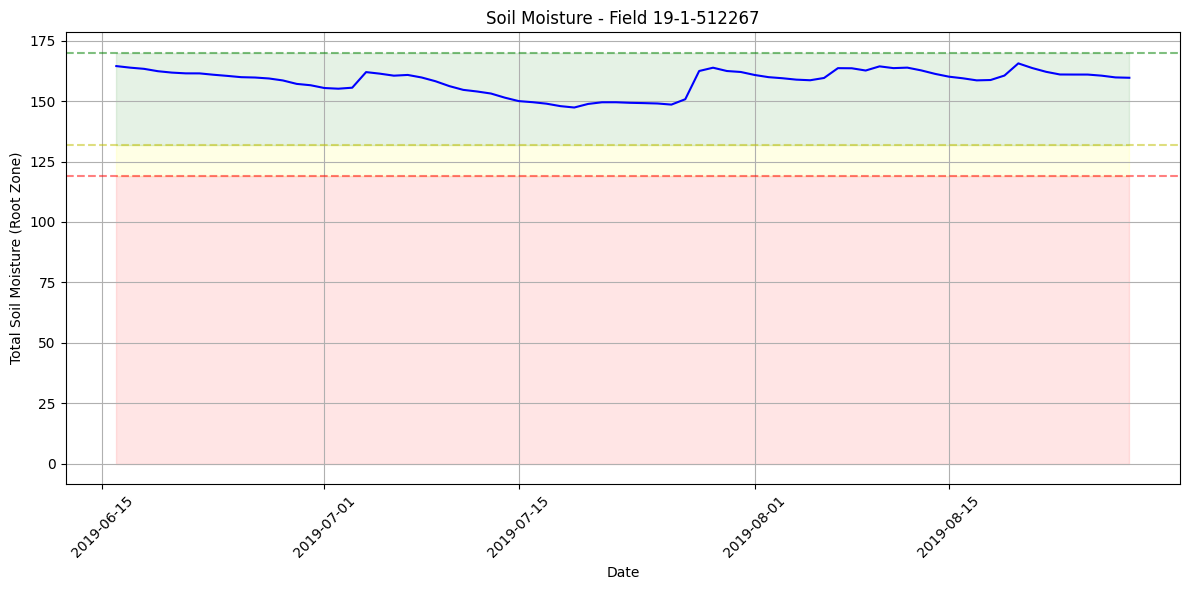

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


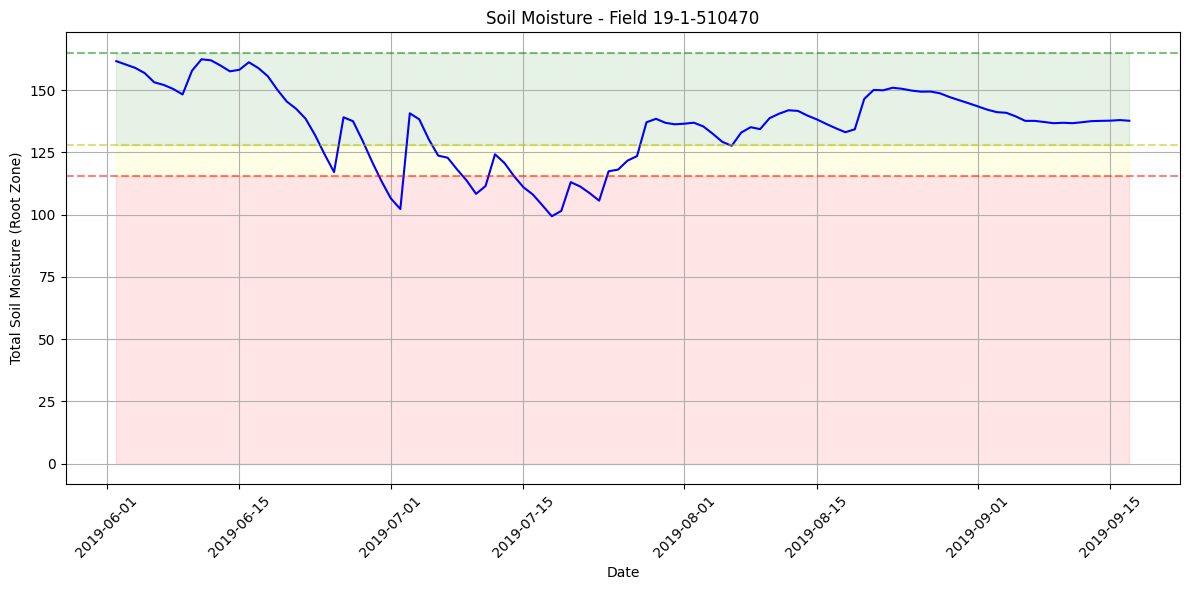

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


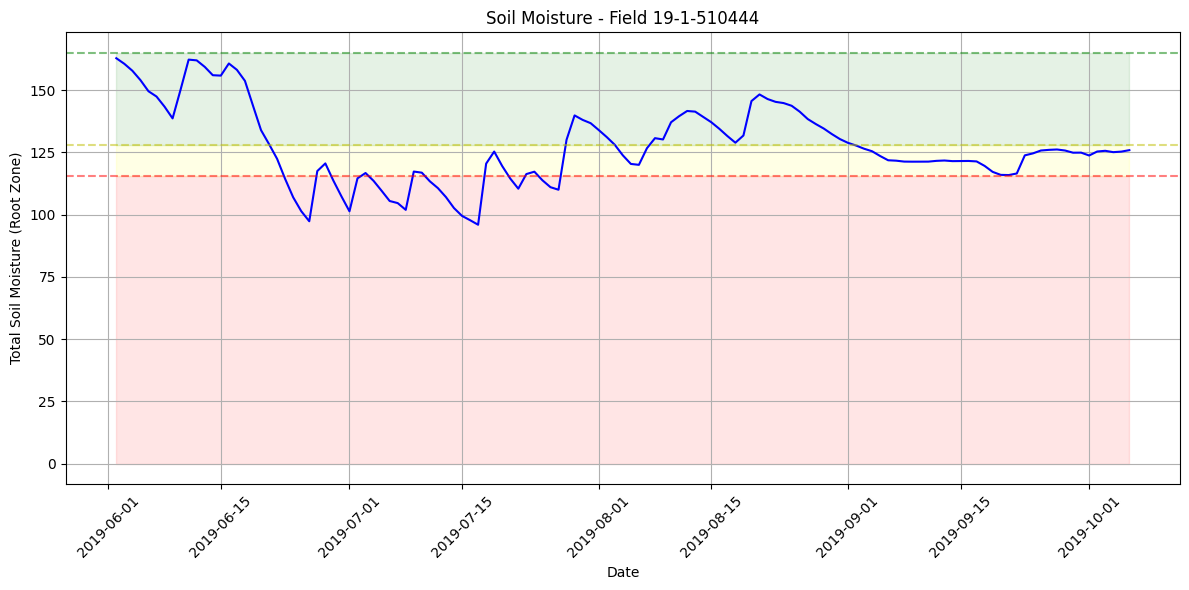

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


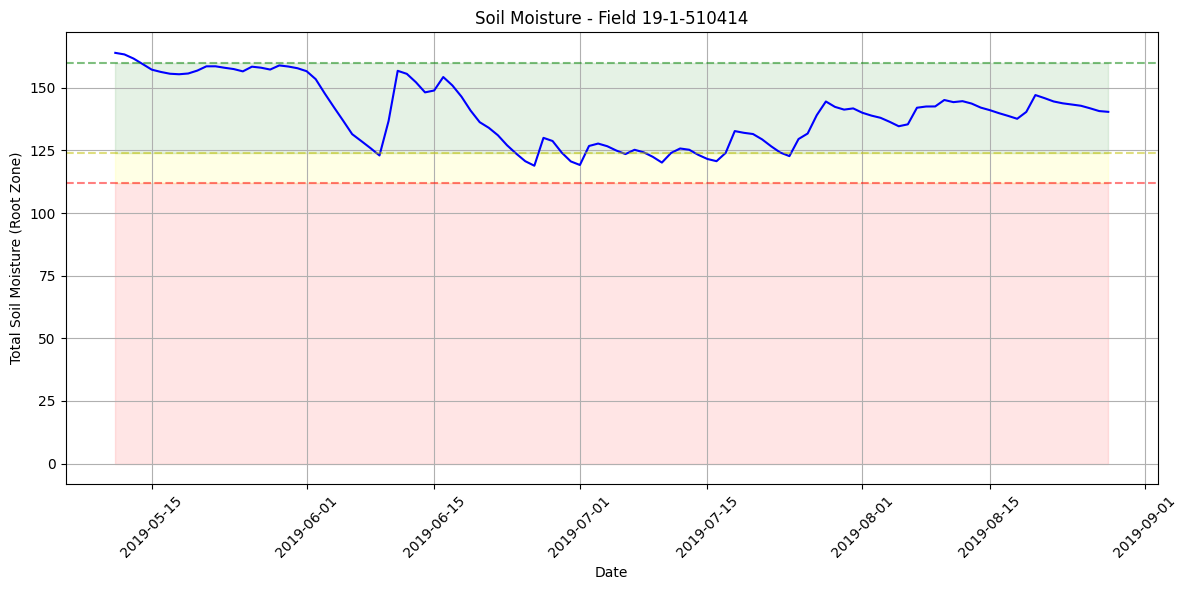

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


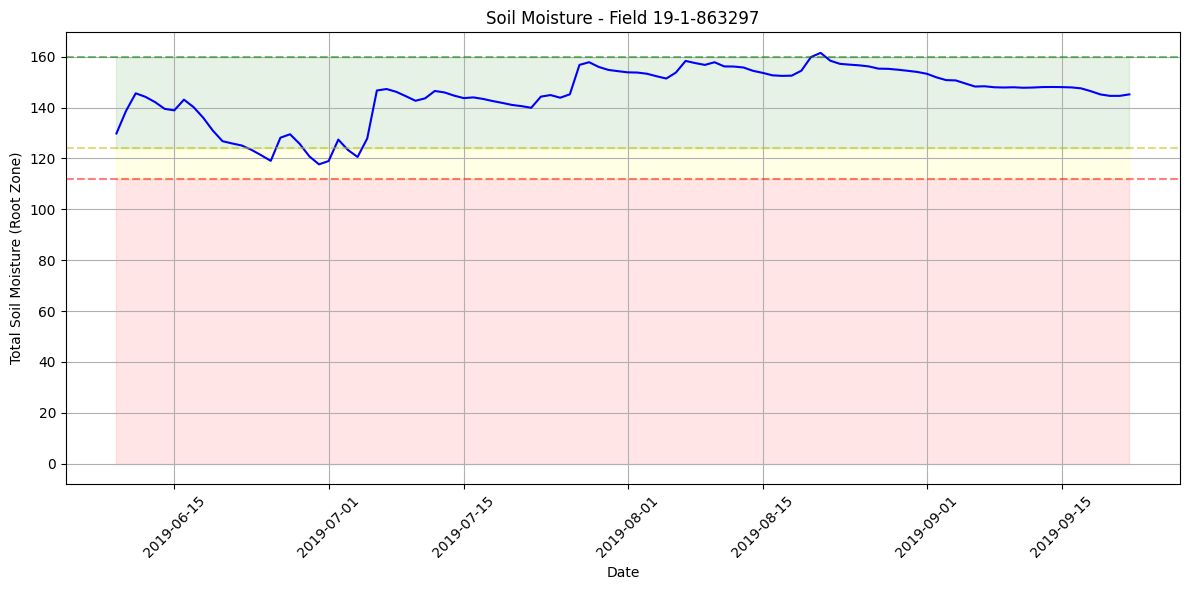

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


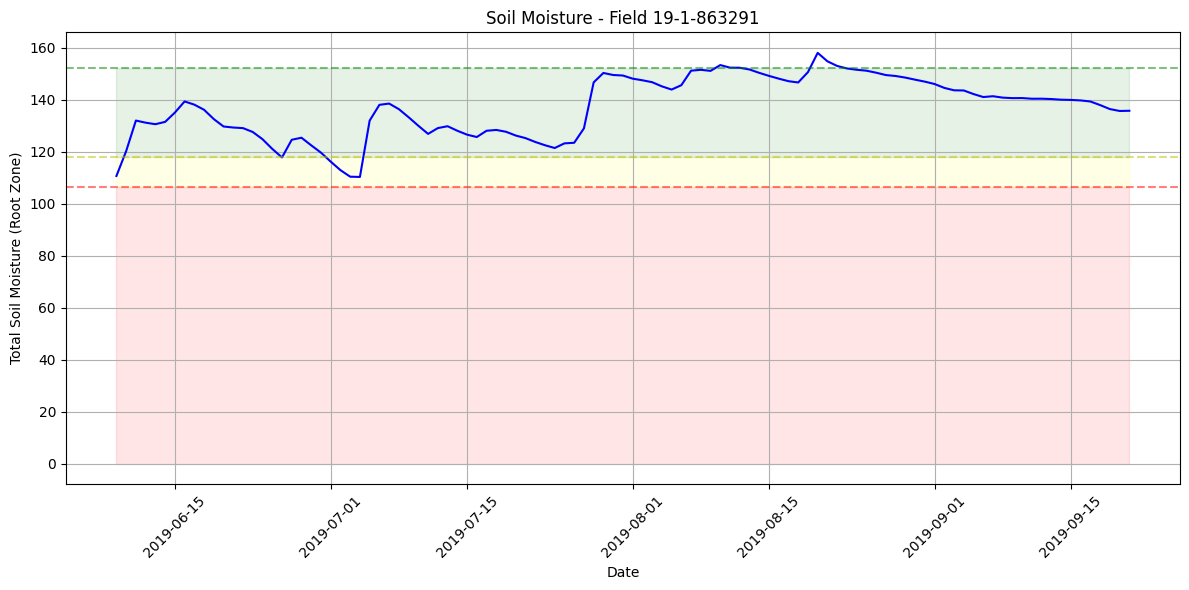

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


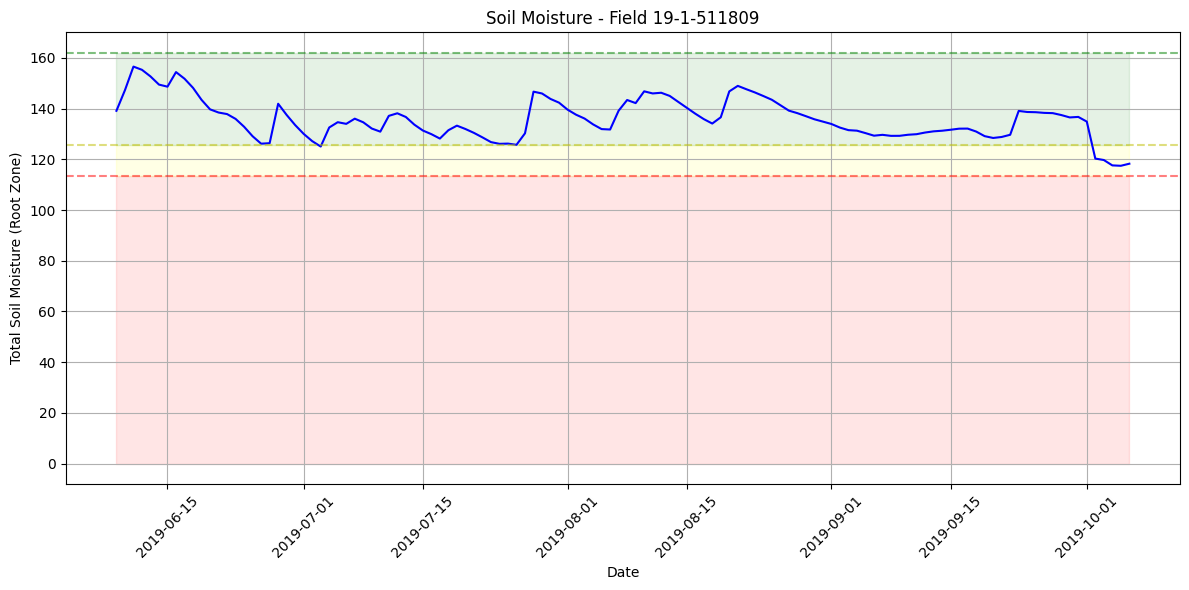

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


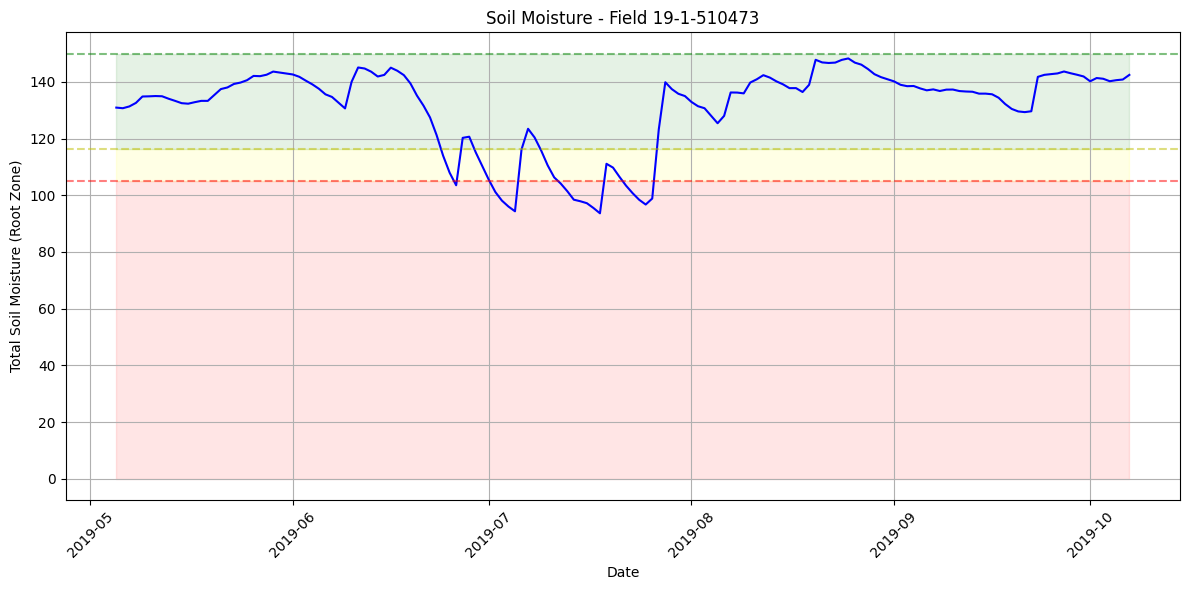

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


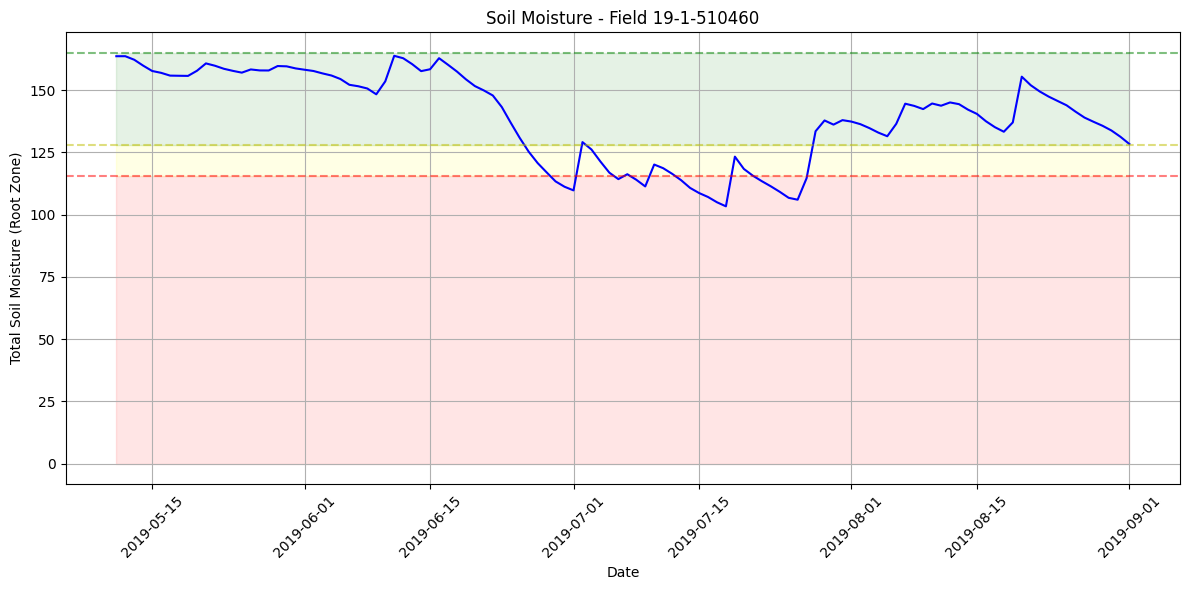

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


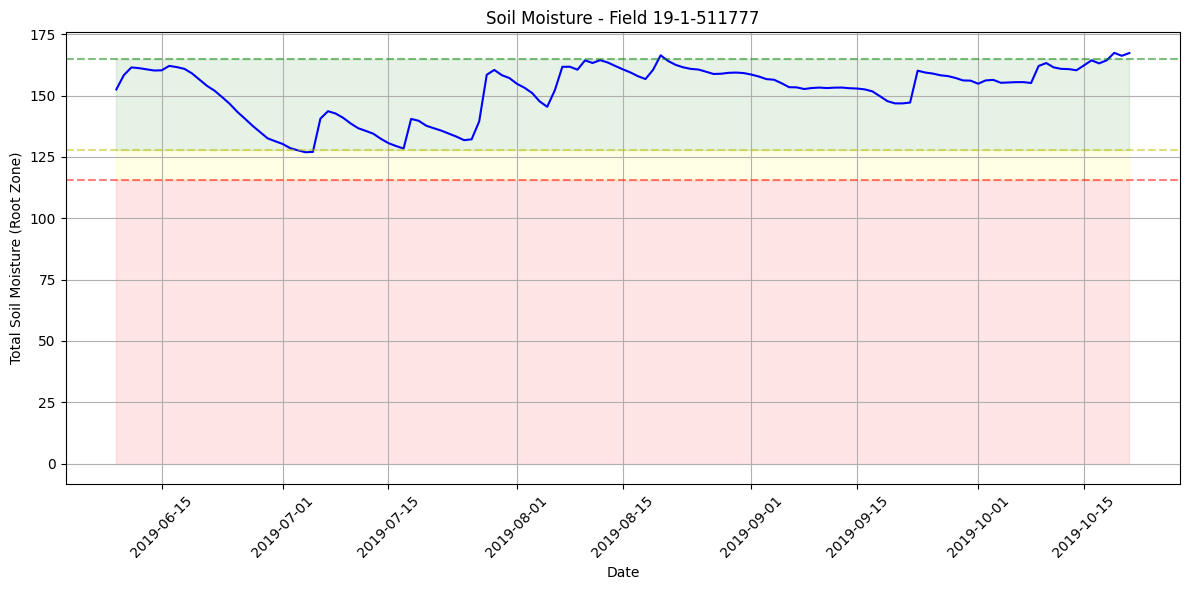

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


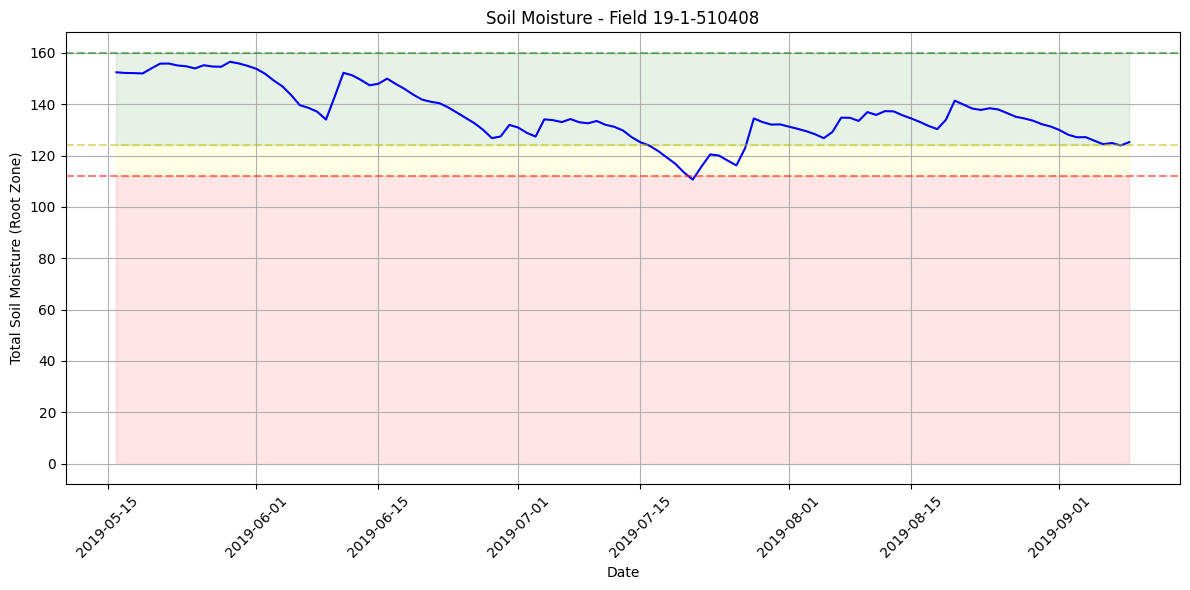

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


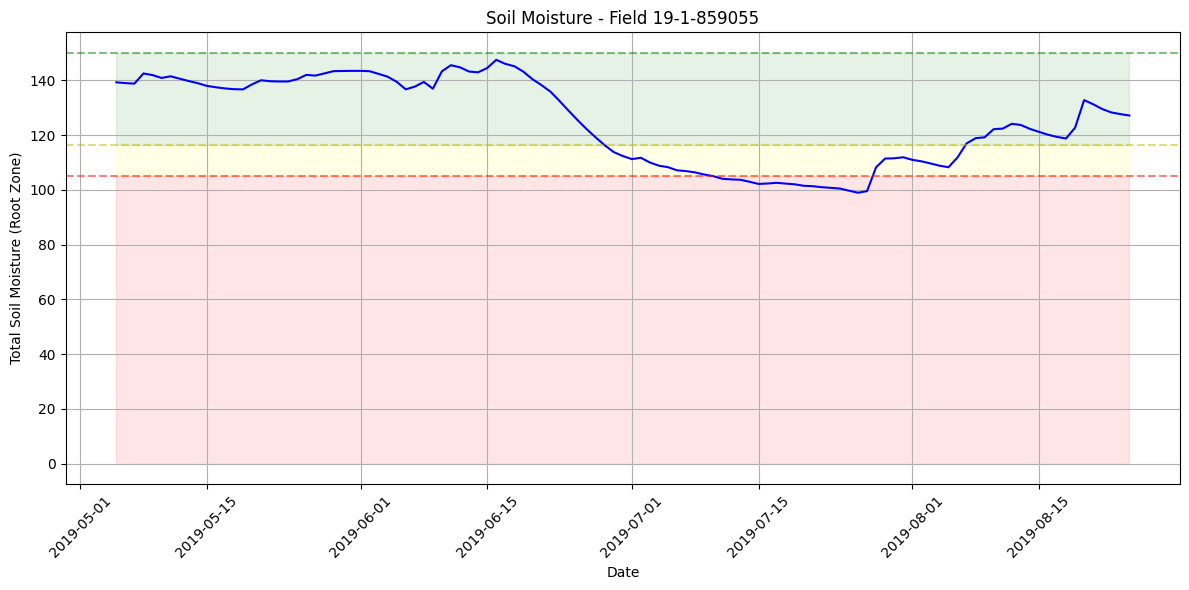

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


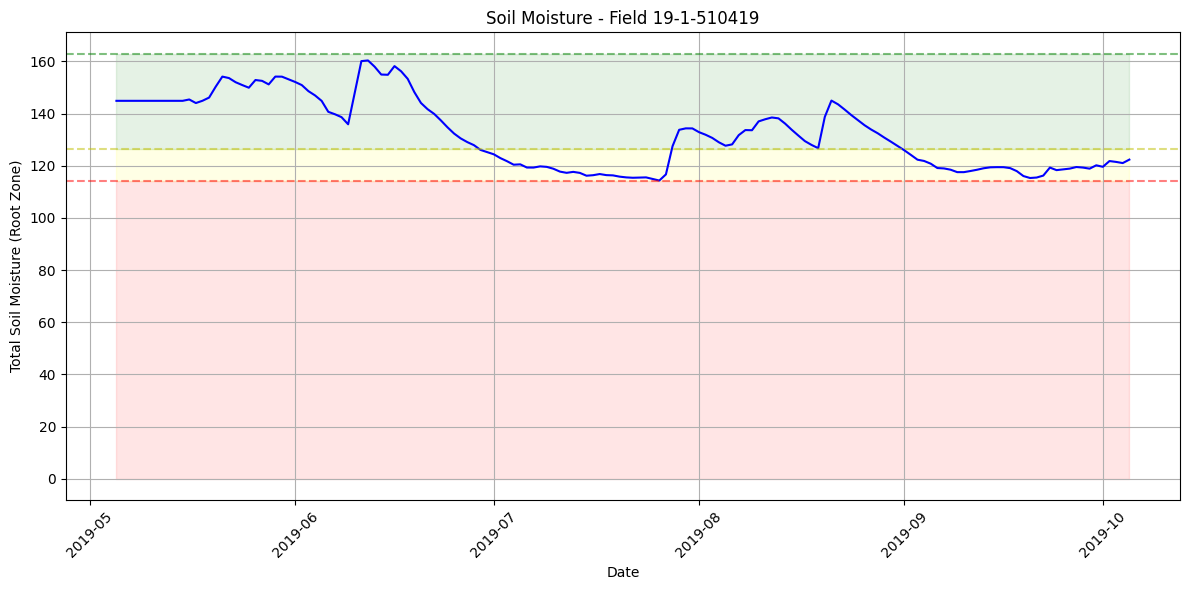

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


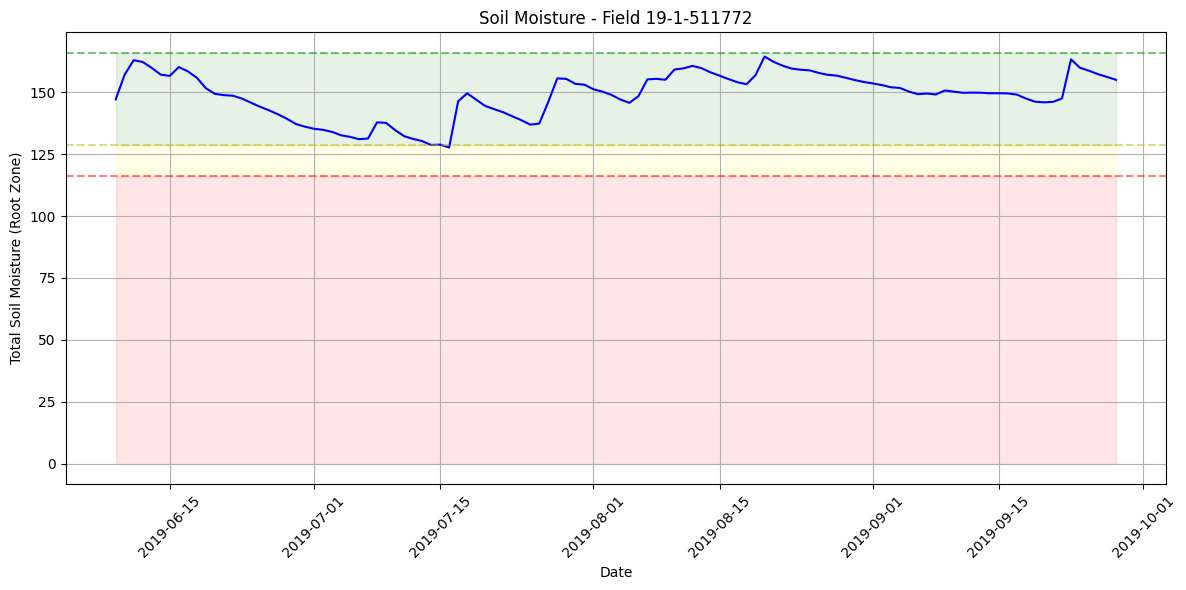

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


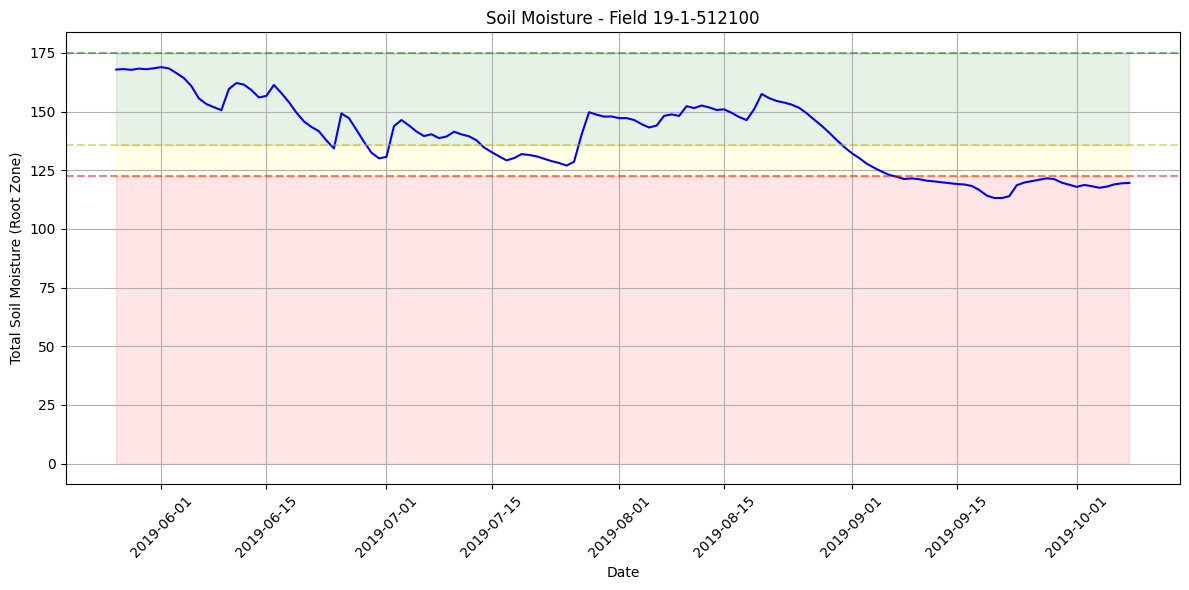

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


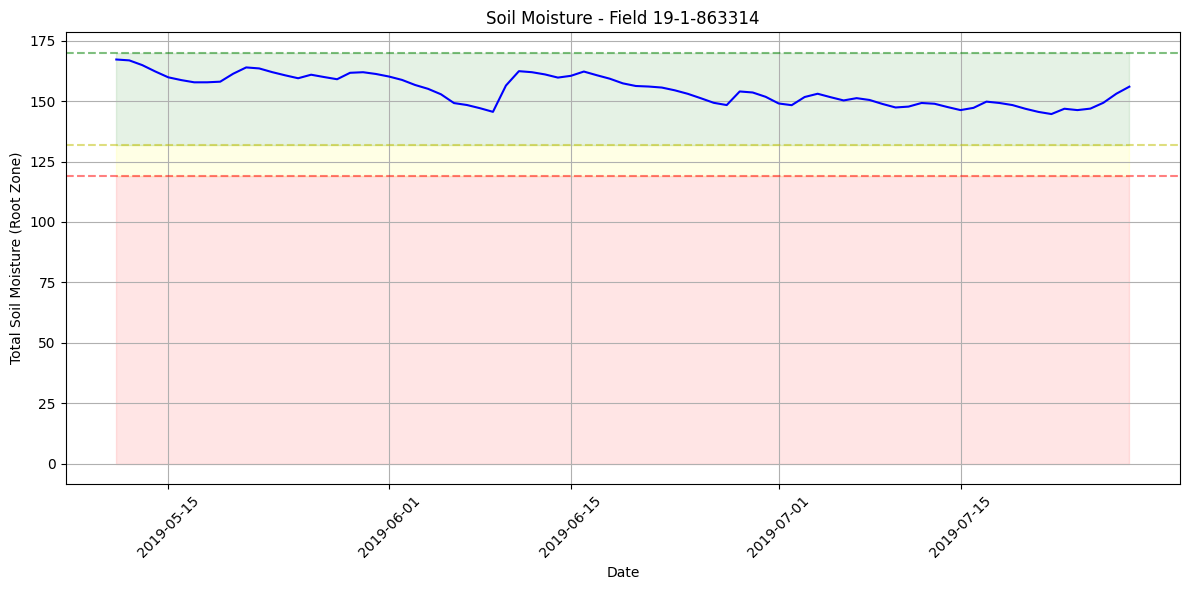

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


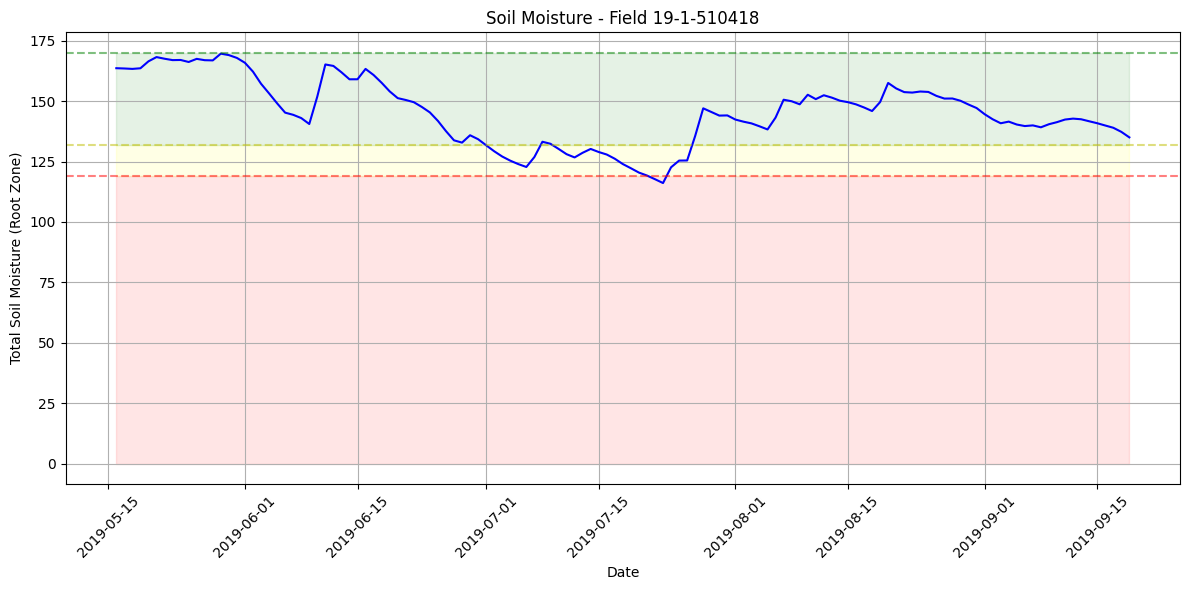

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


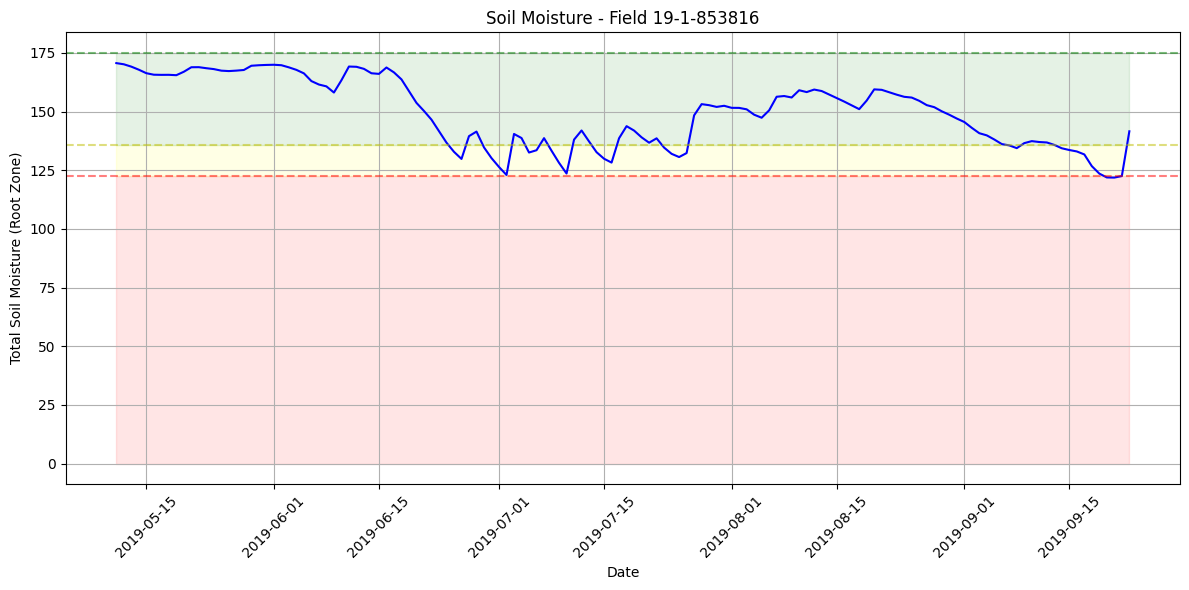

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


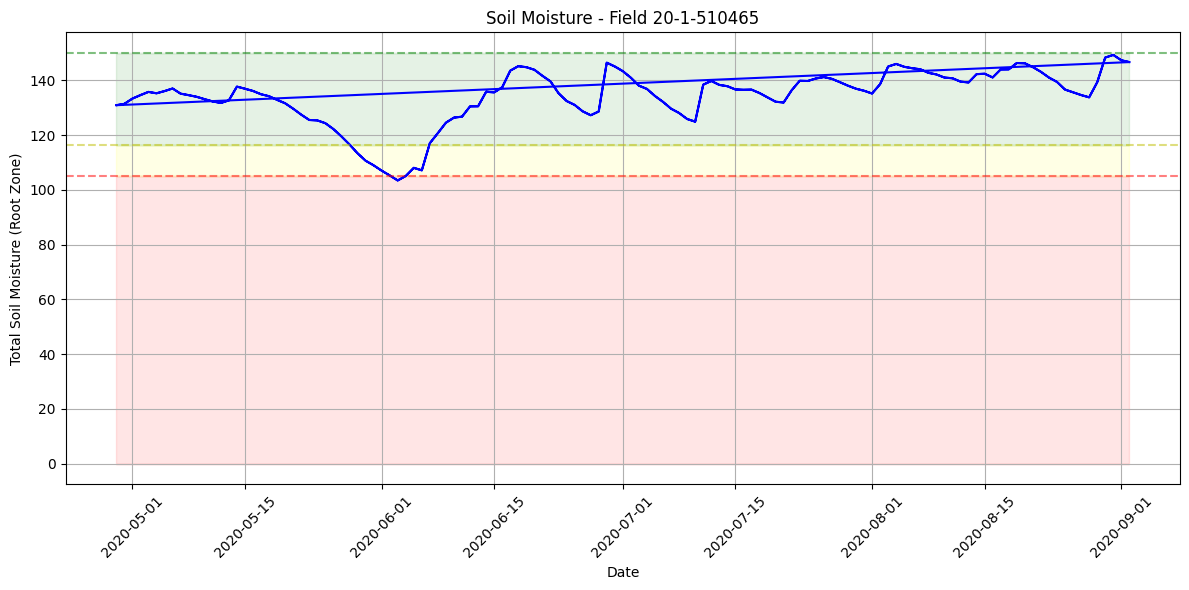

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


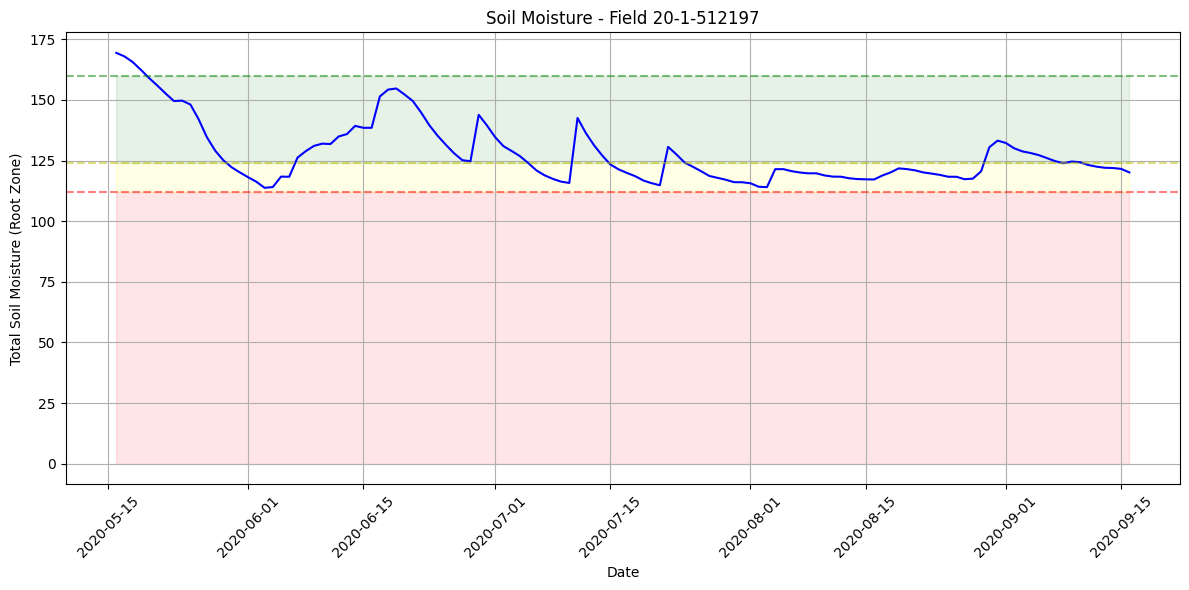

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


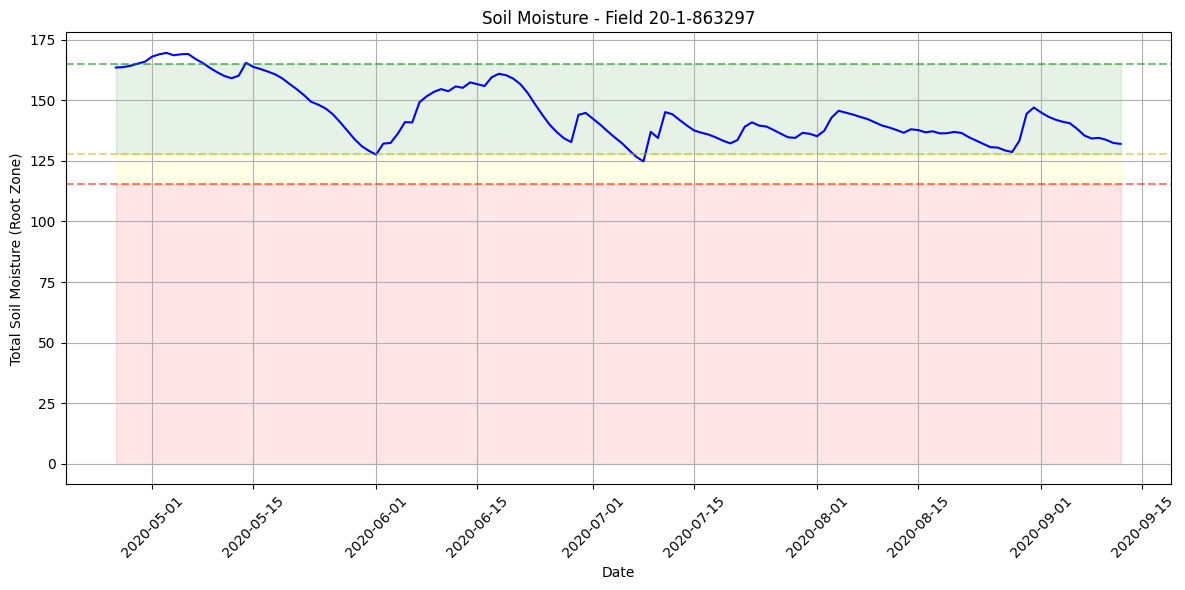

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


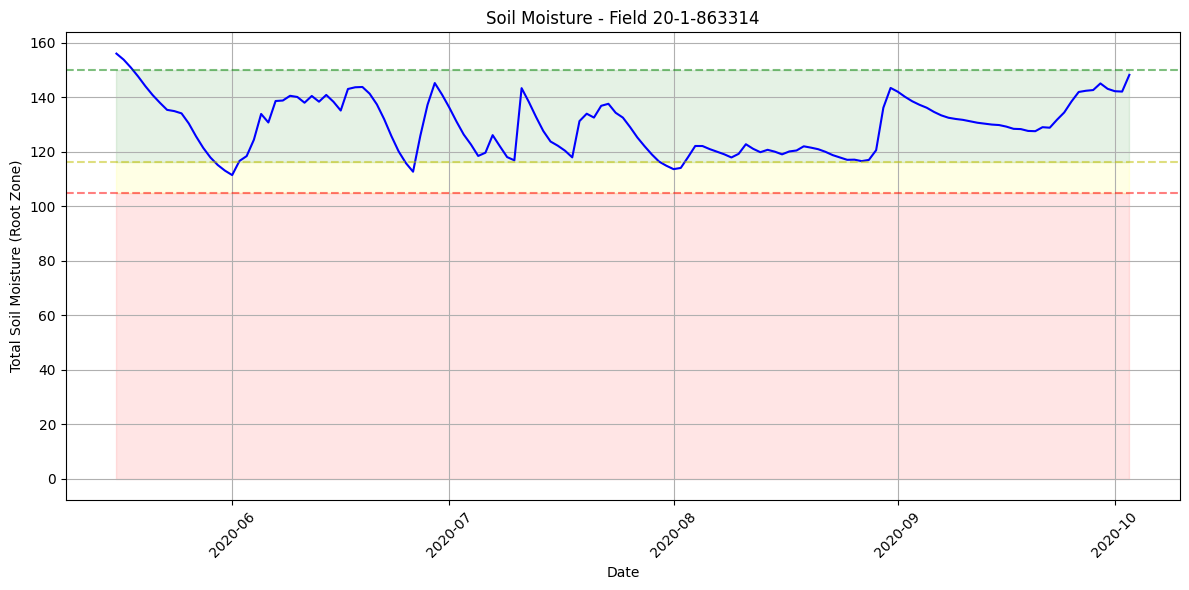

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


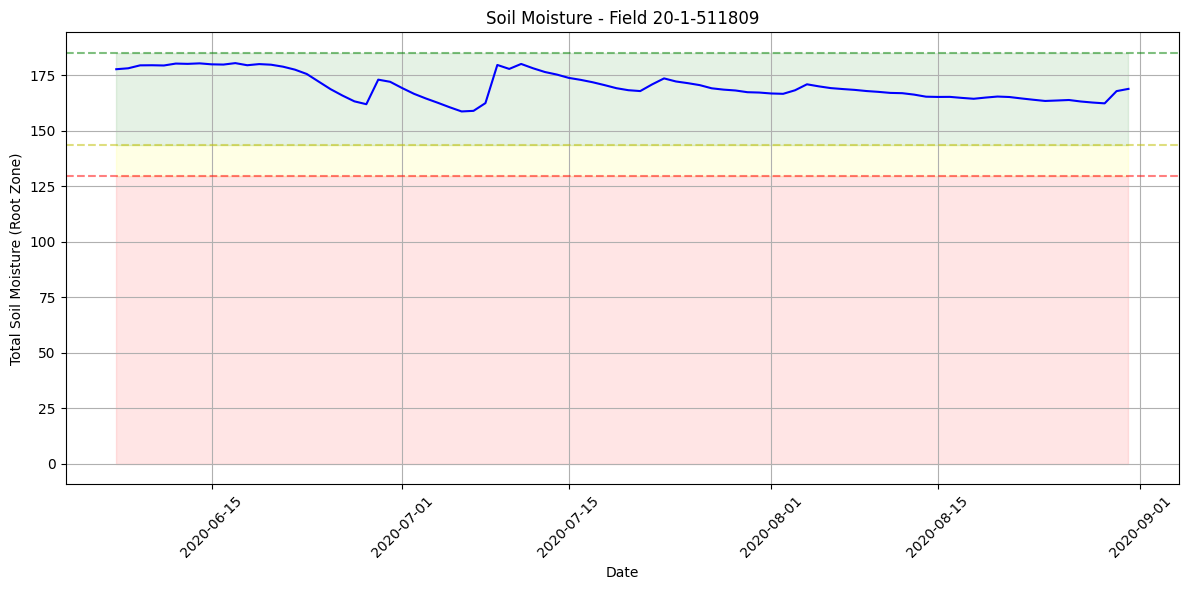

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


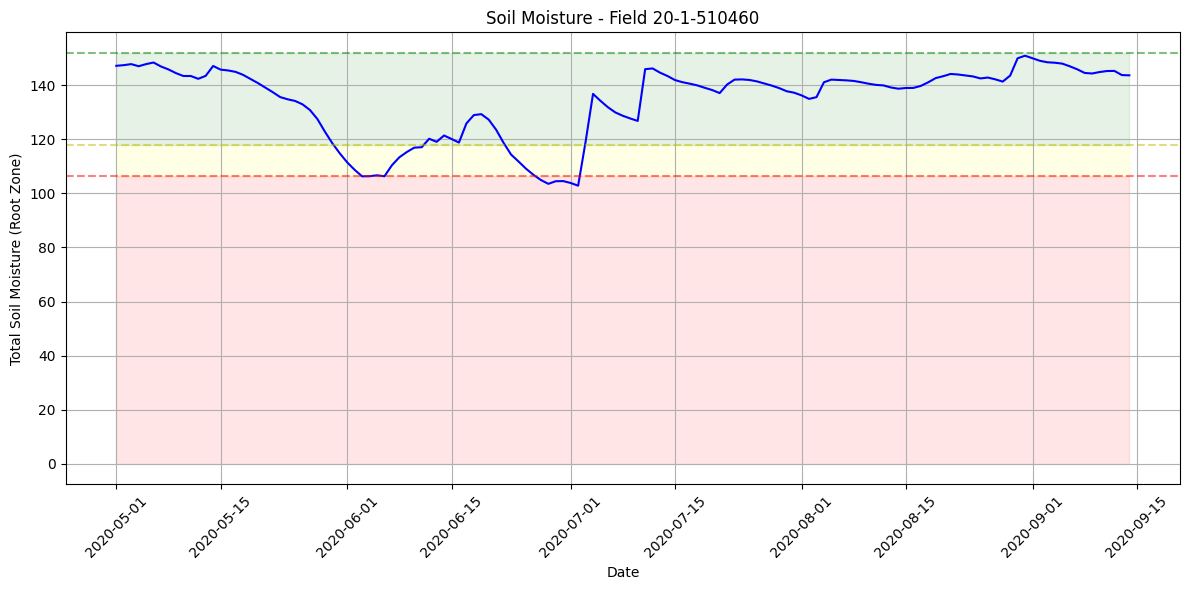

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


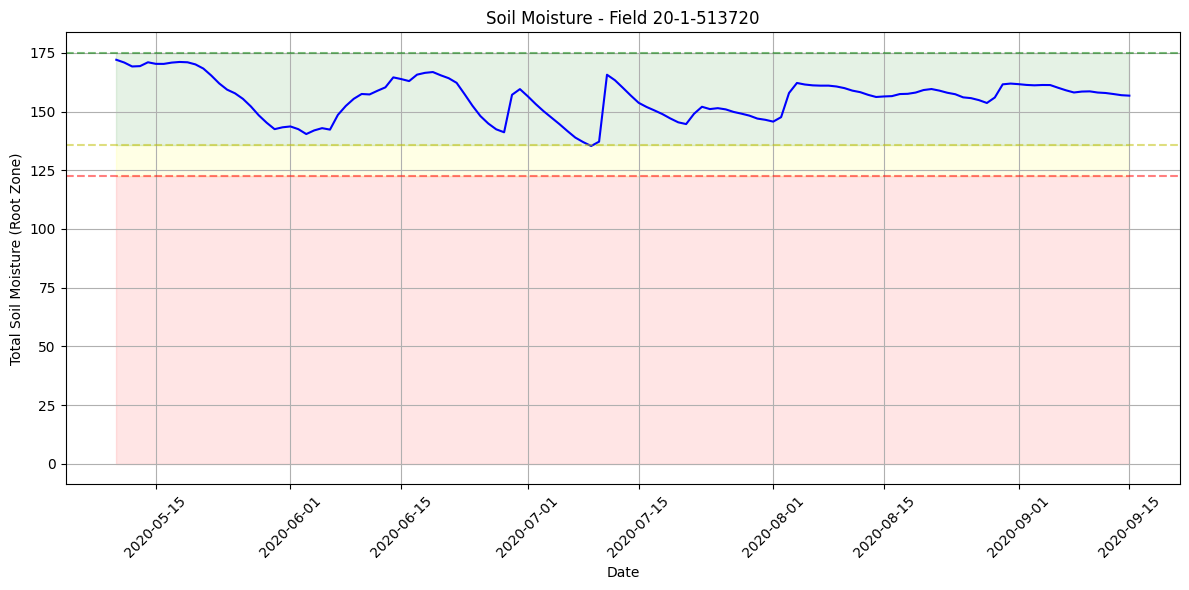

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


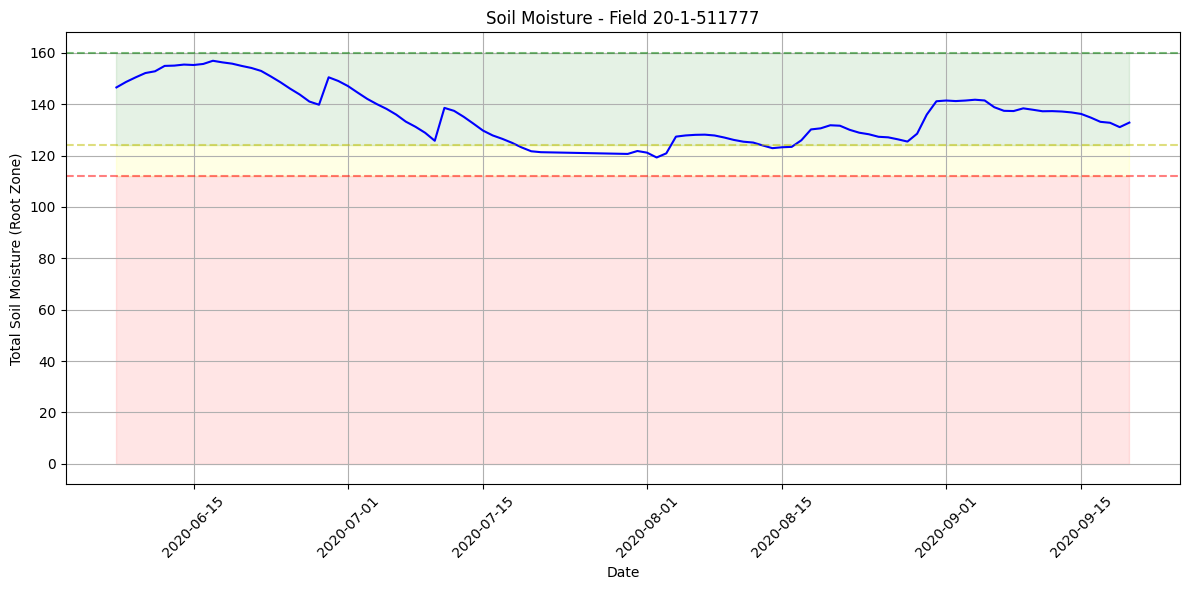

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


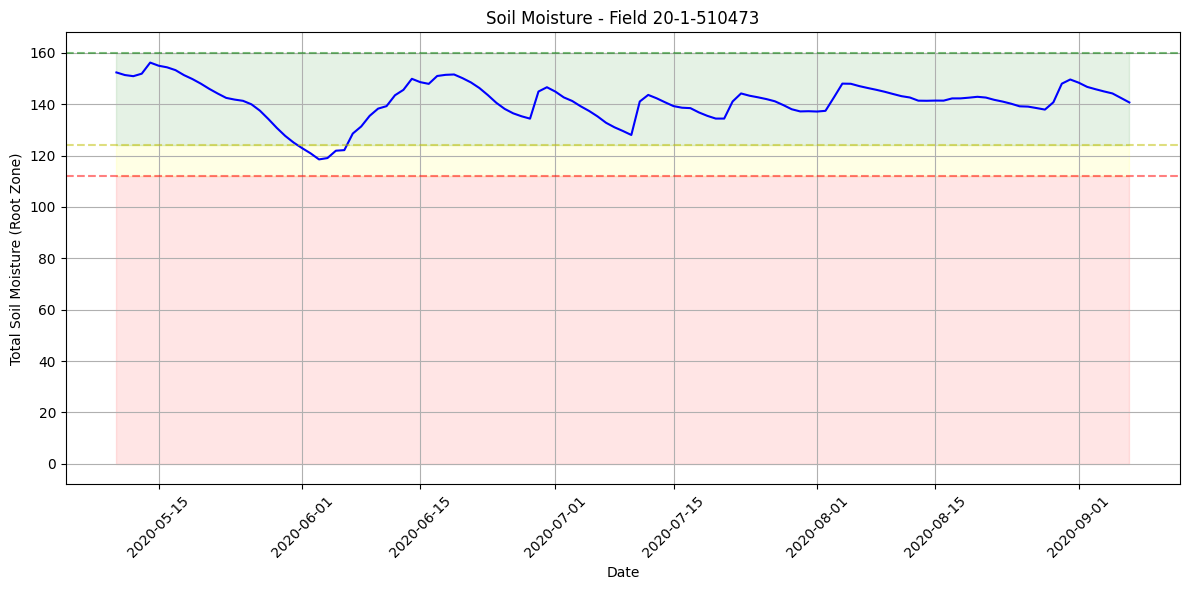

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


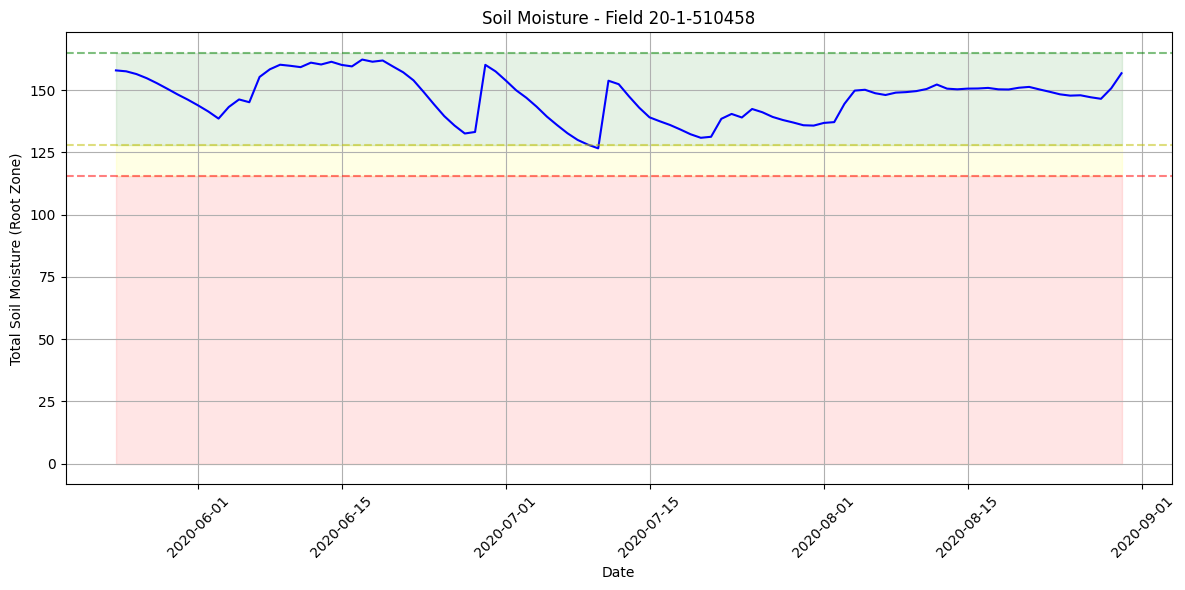

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


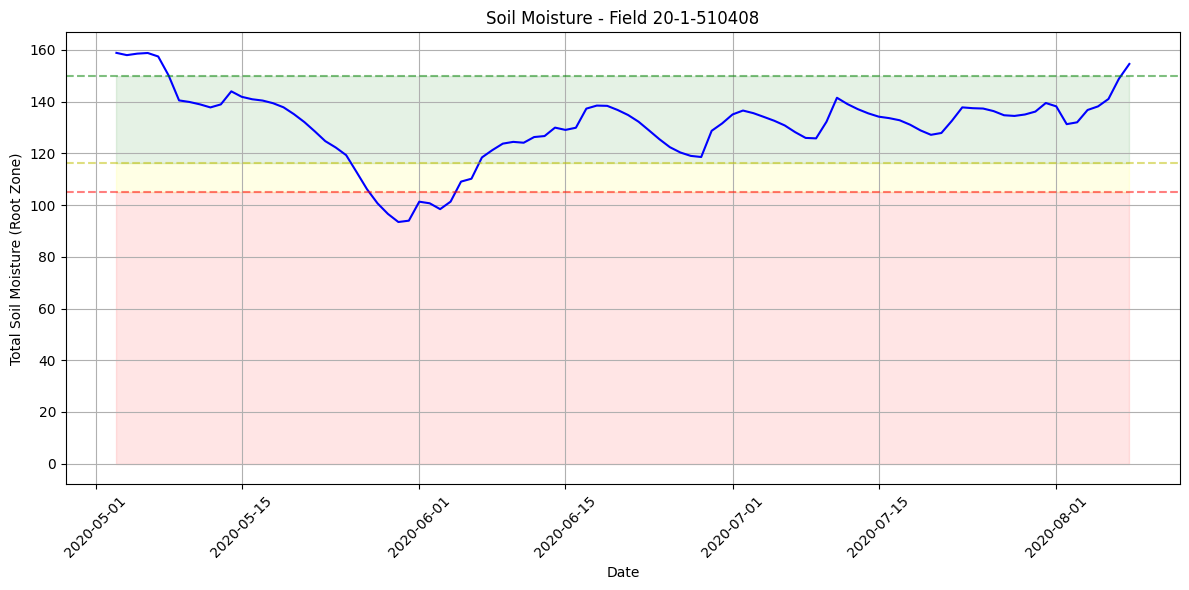

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


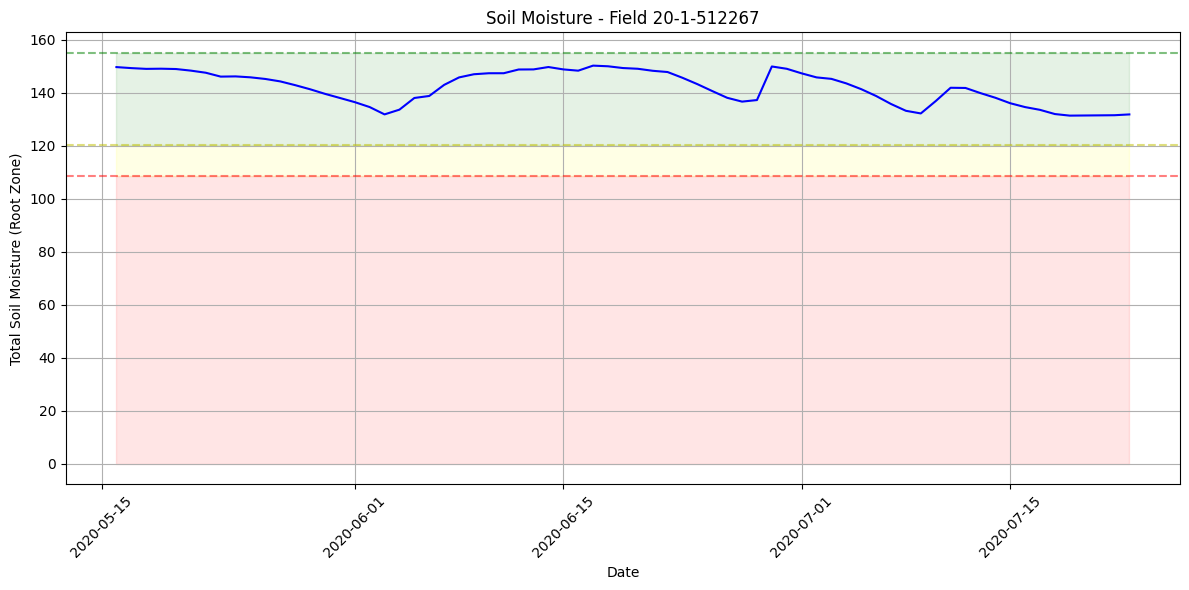

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


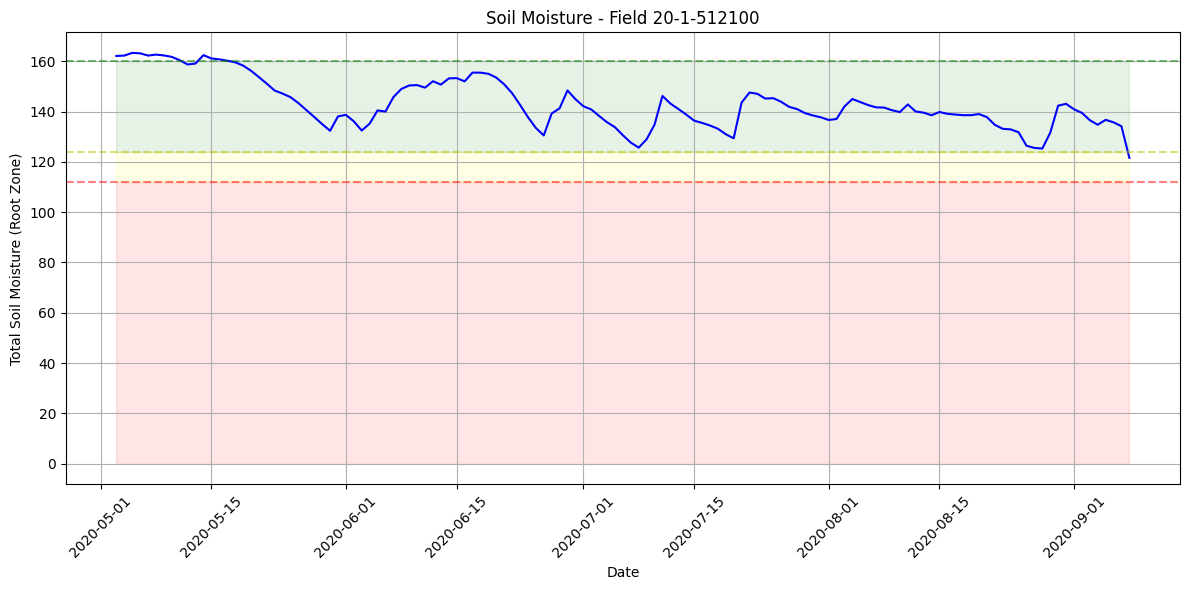

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


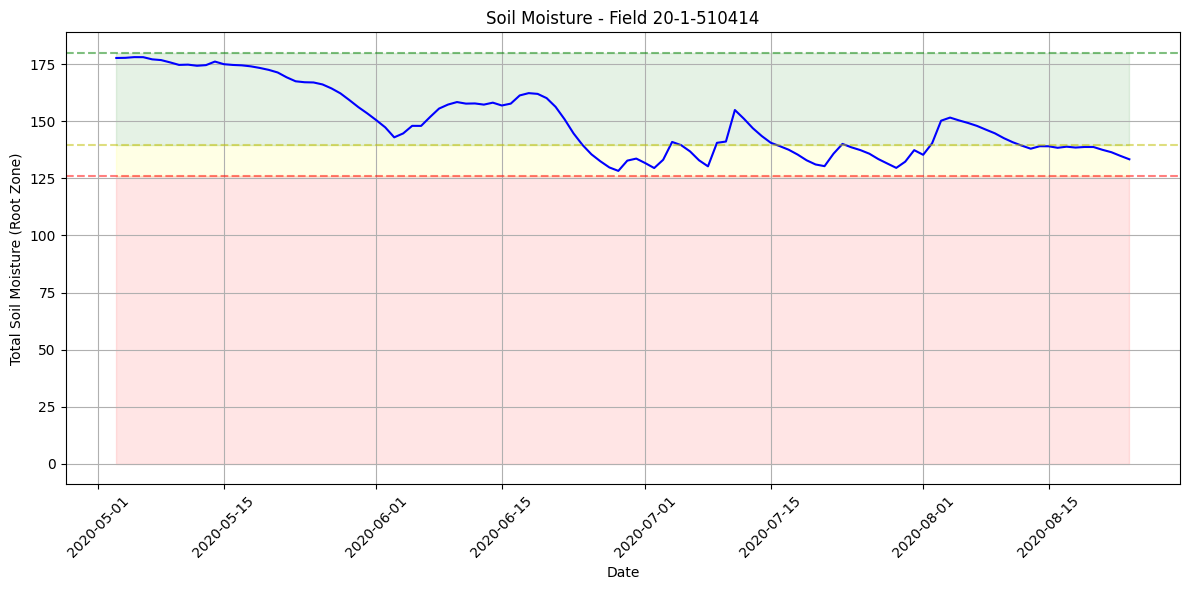

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


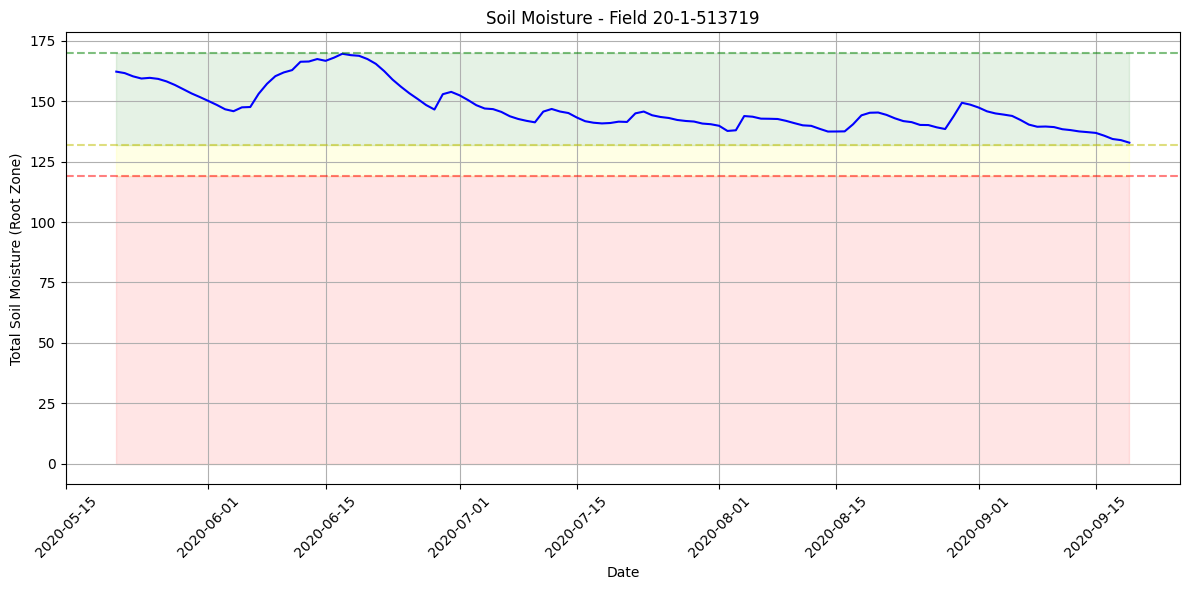

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


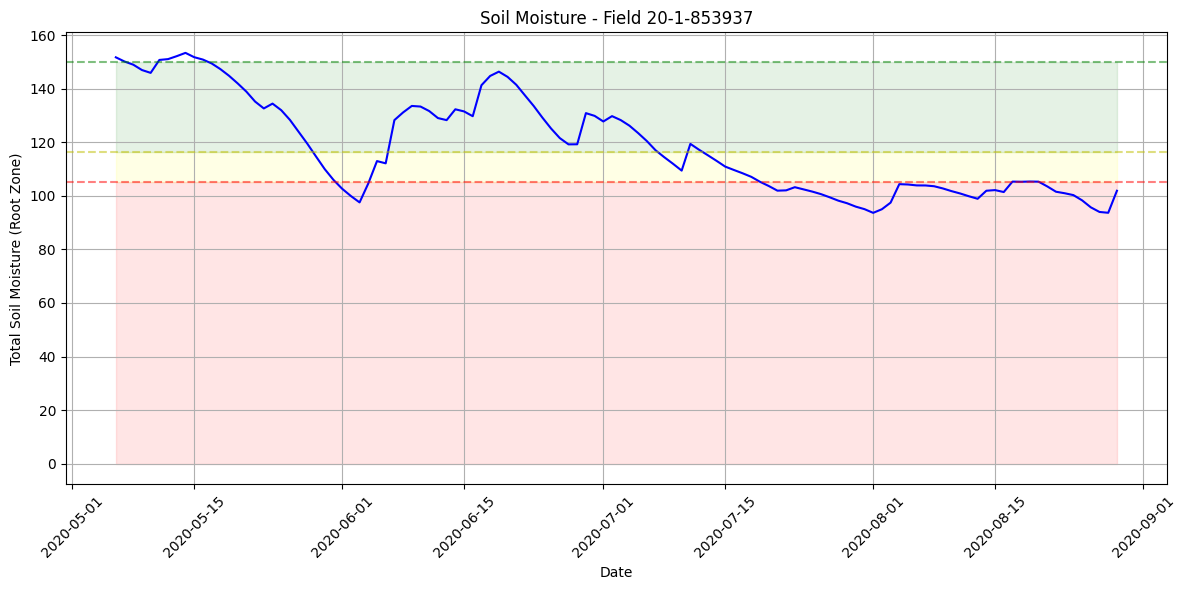

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


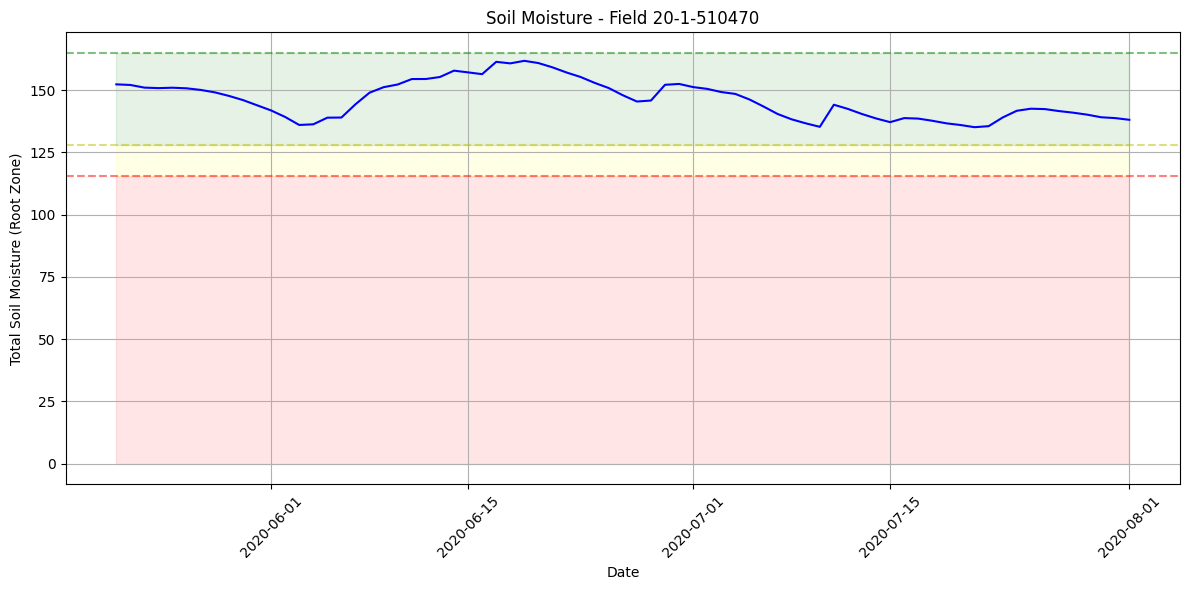

Error plotting field 20-1-513609


/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


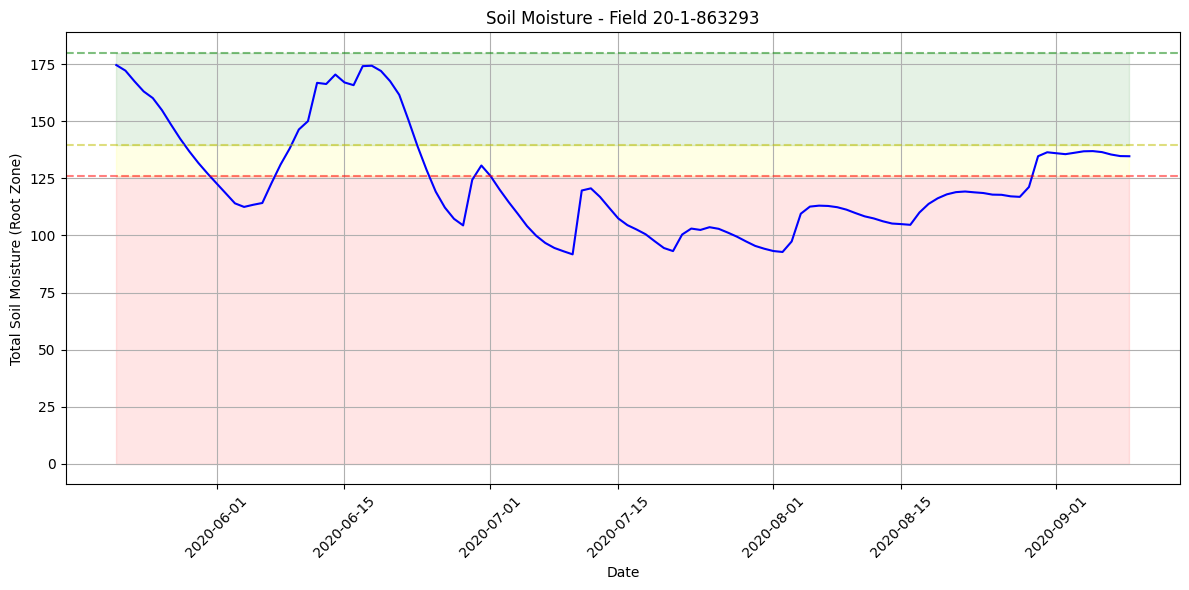

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


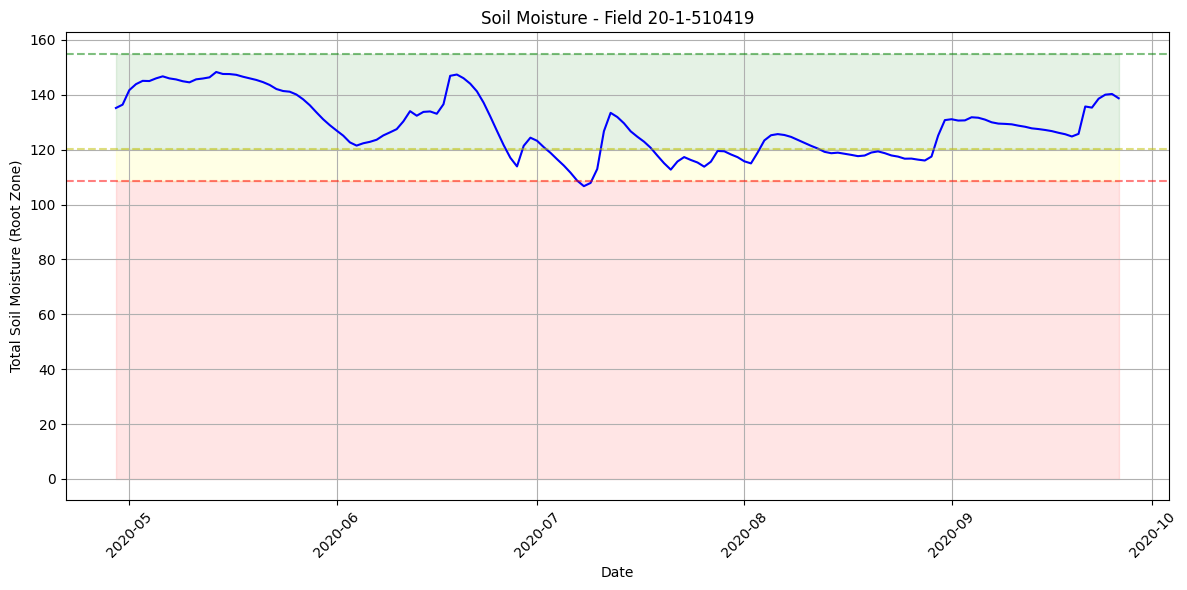

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


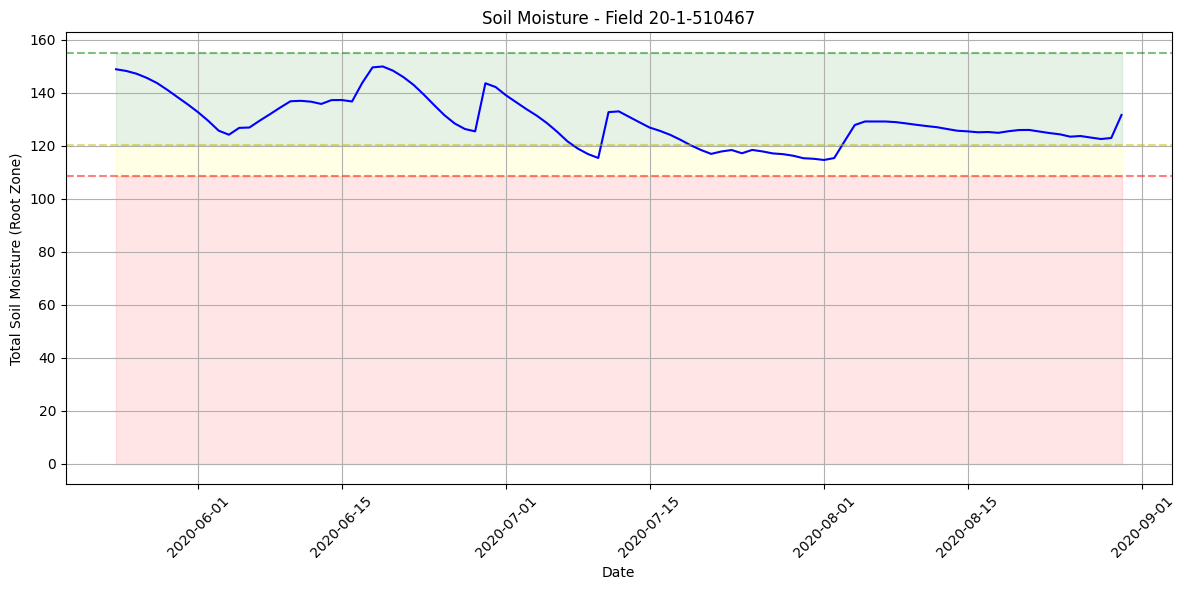

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


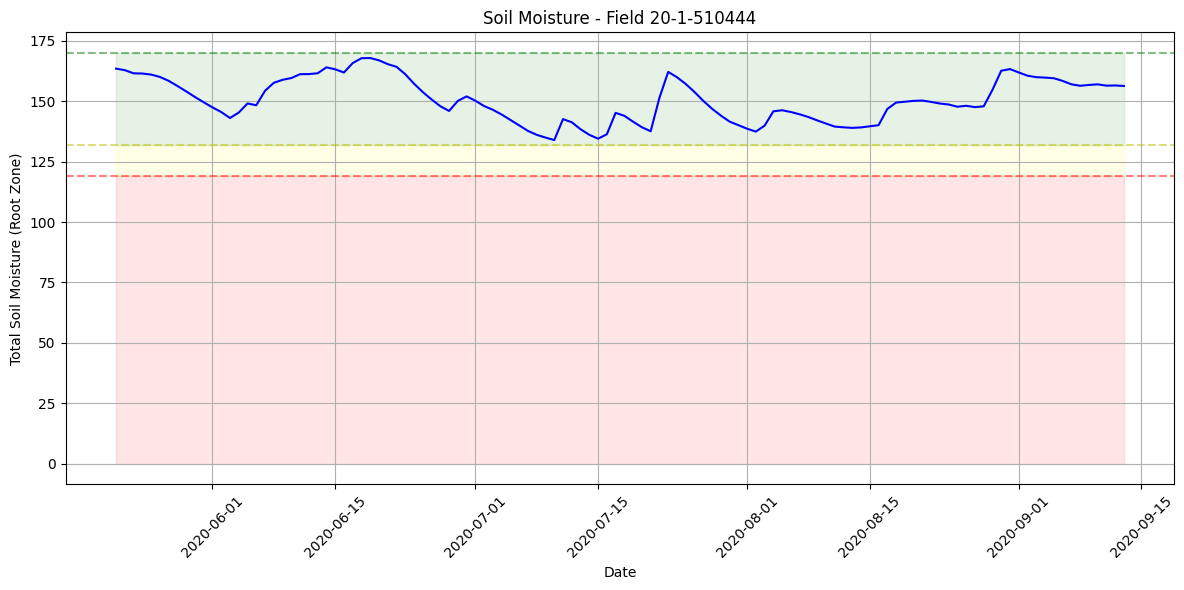

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


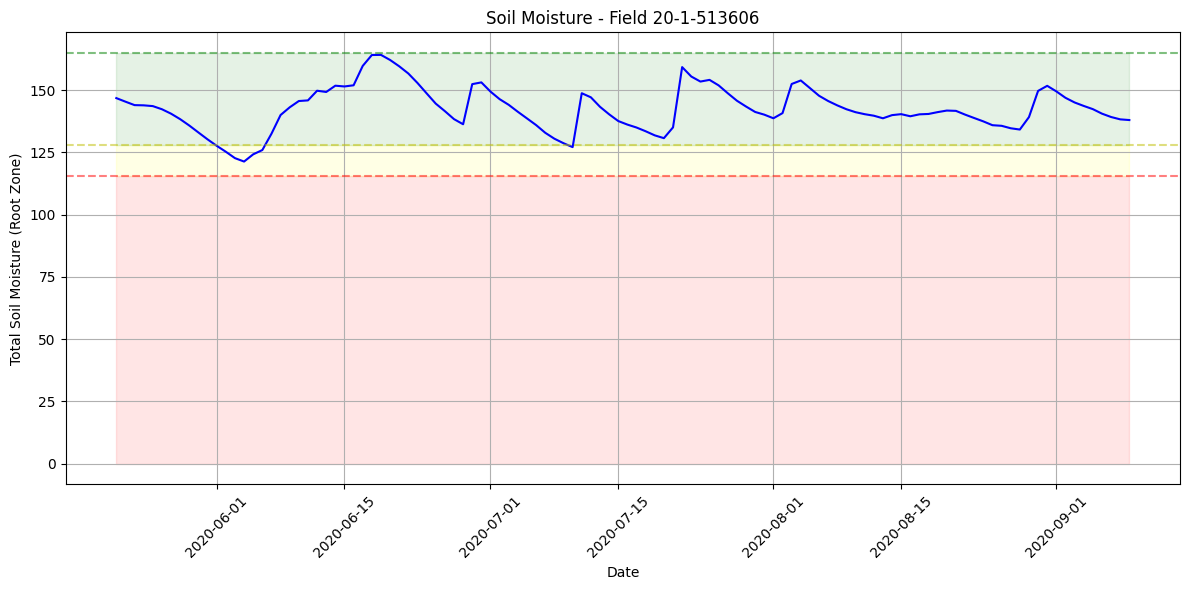

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


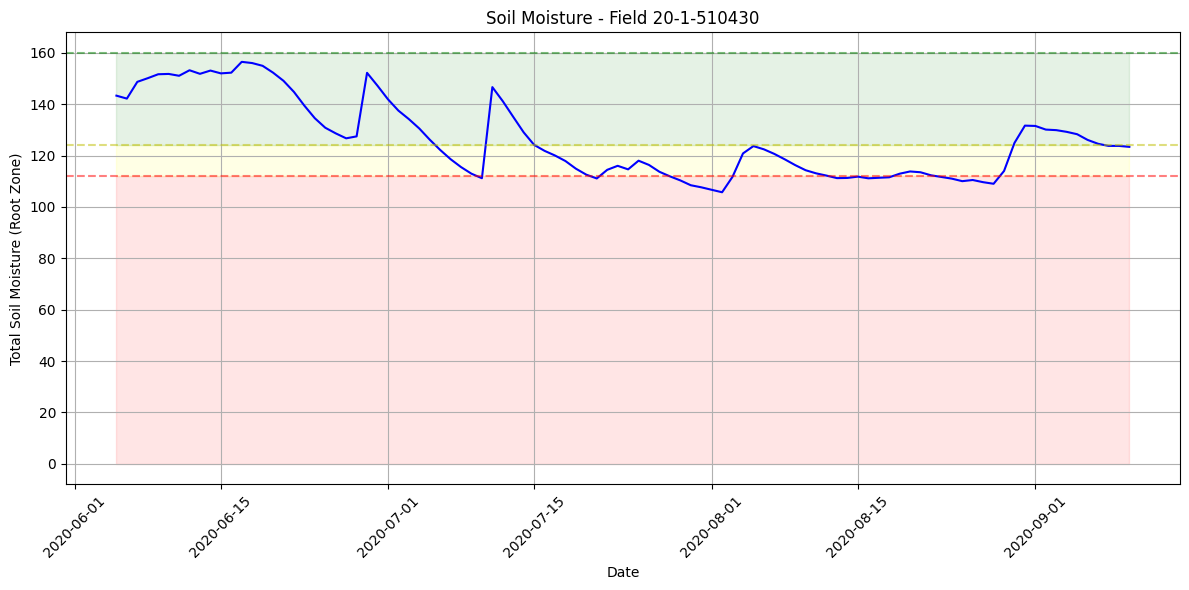

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


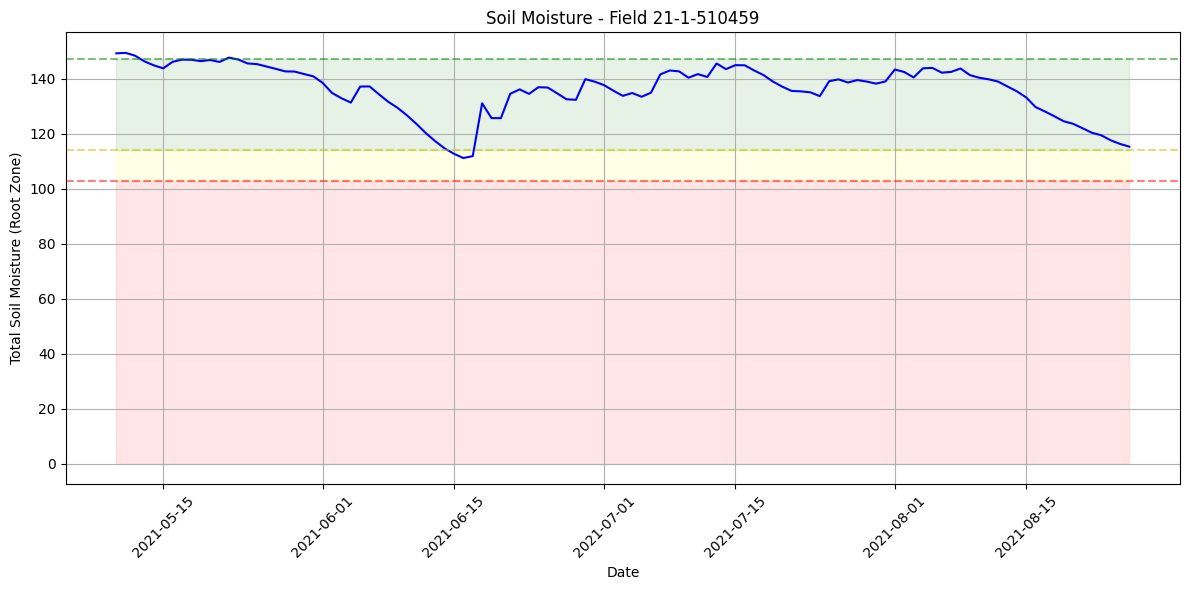

Error plotting field 21-1-513726


/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


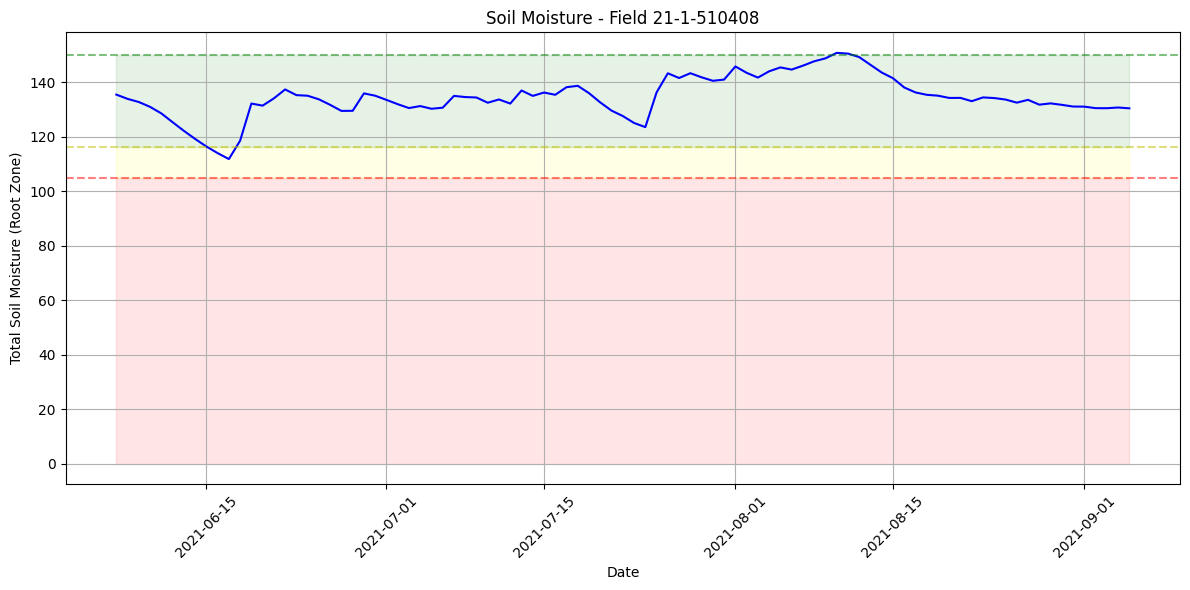

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


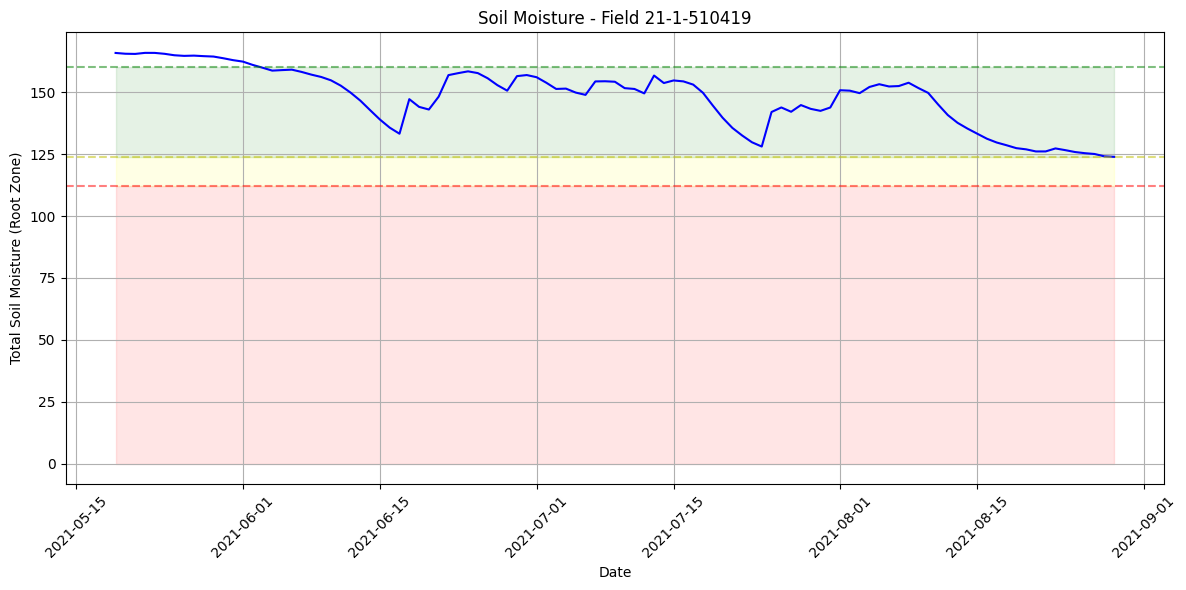

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


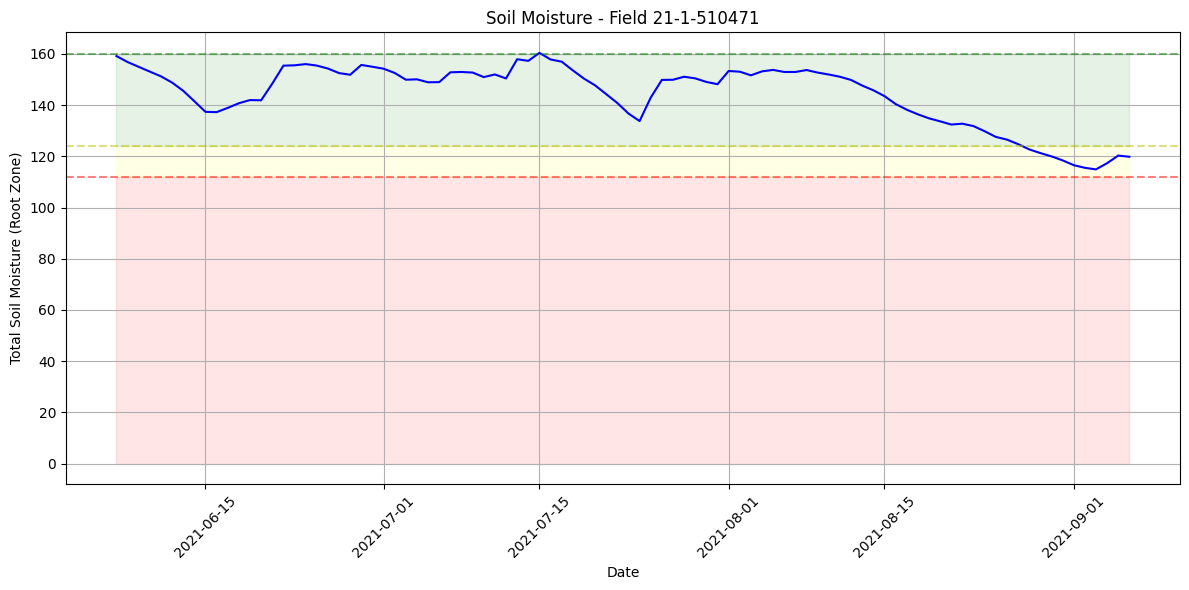

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


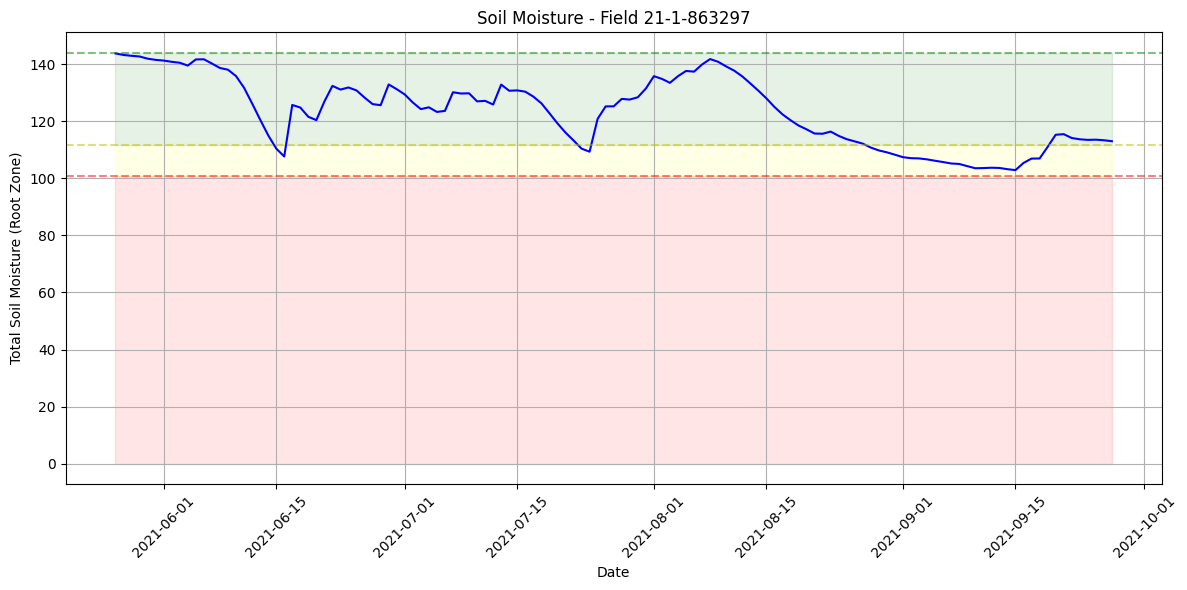

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


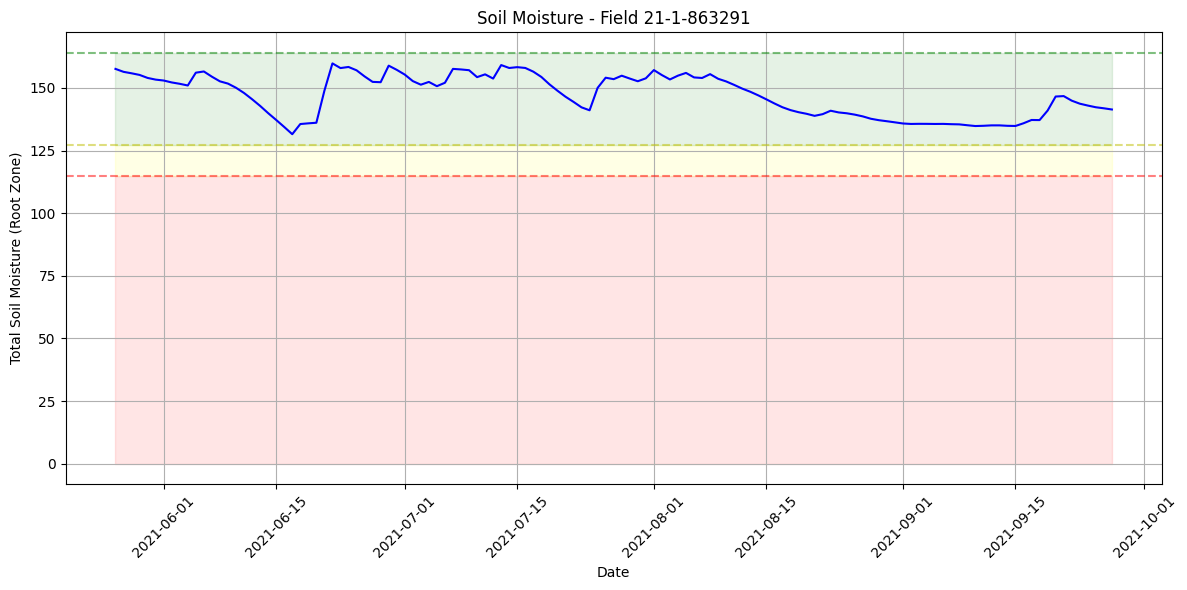

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


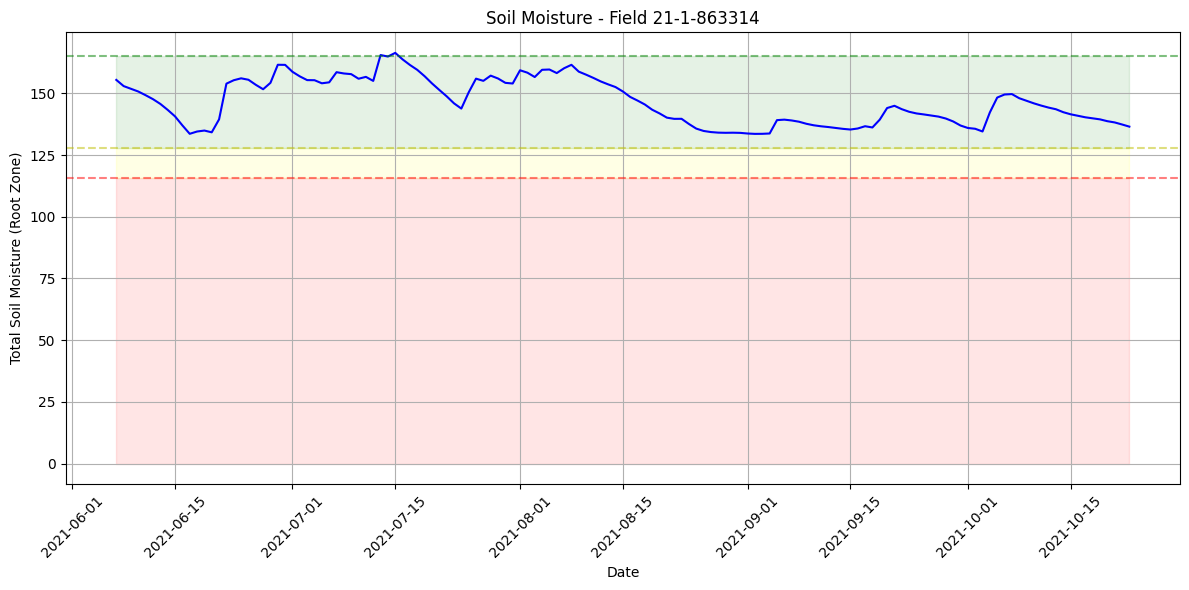

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


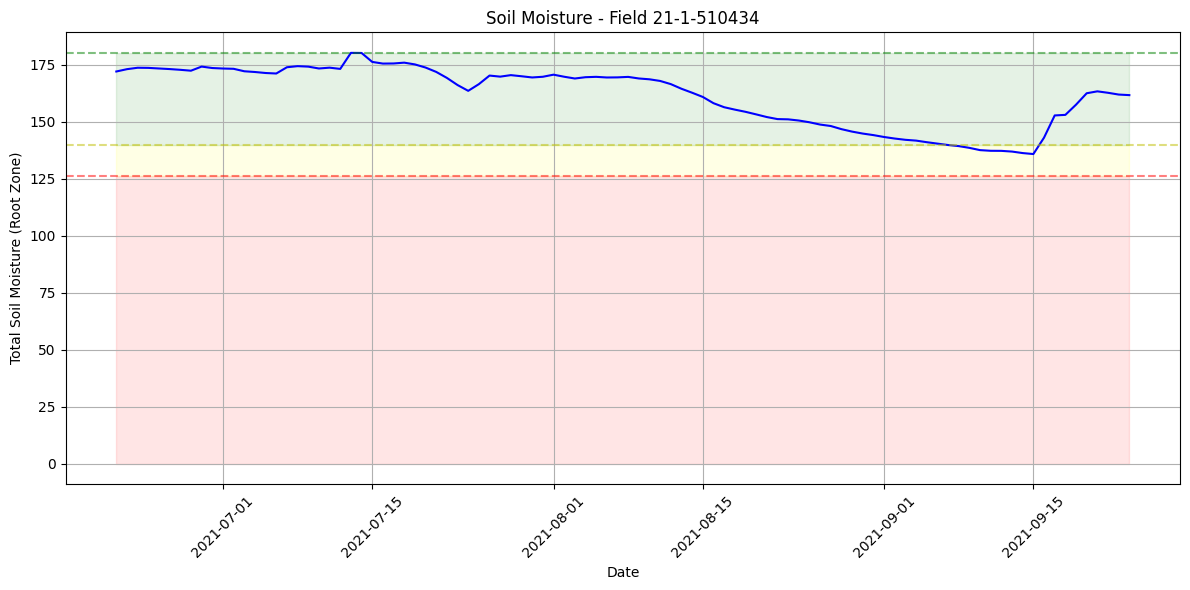

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


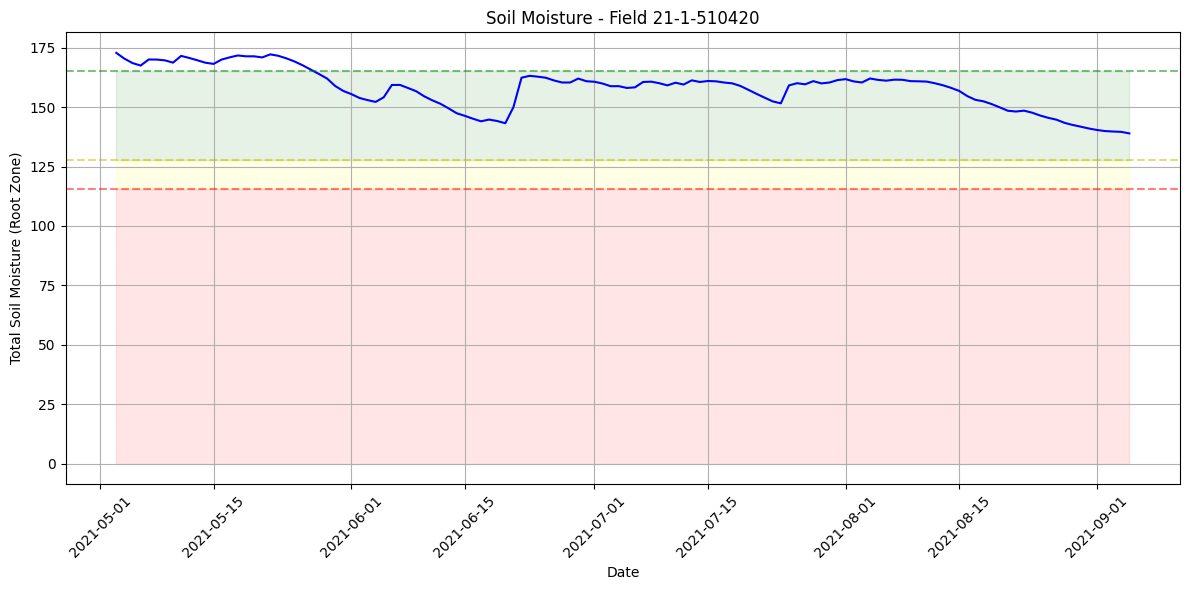

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


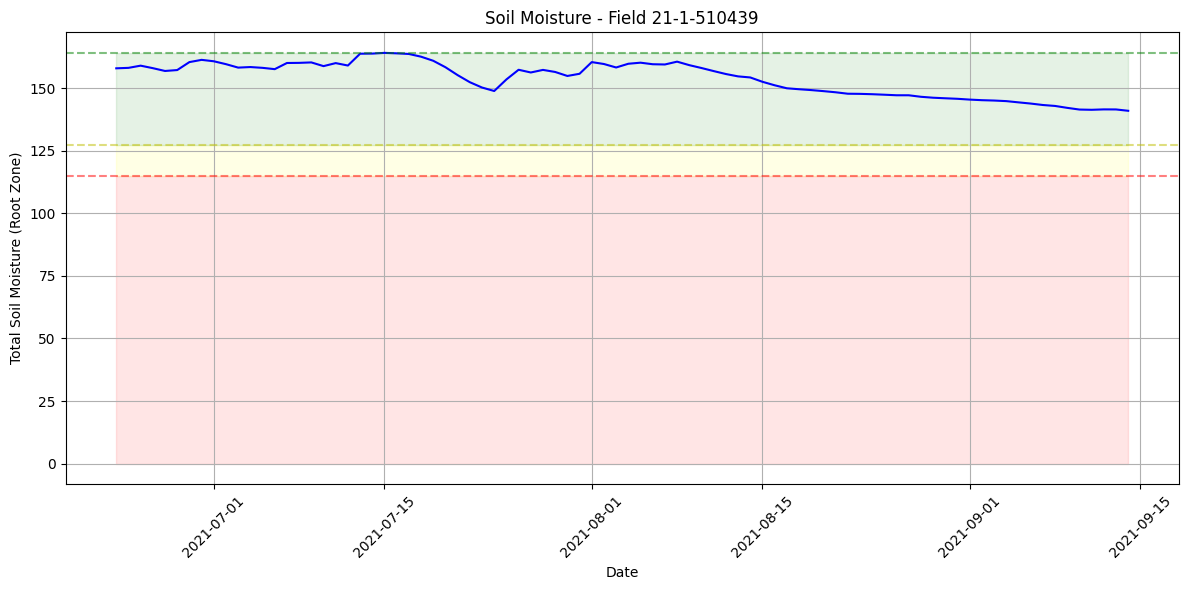

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


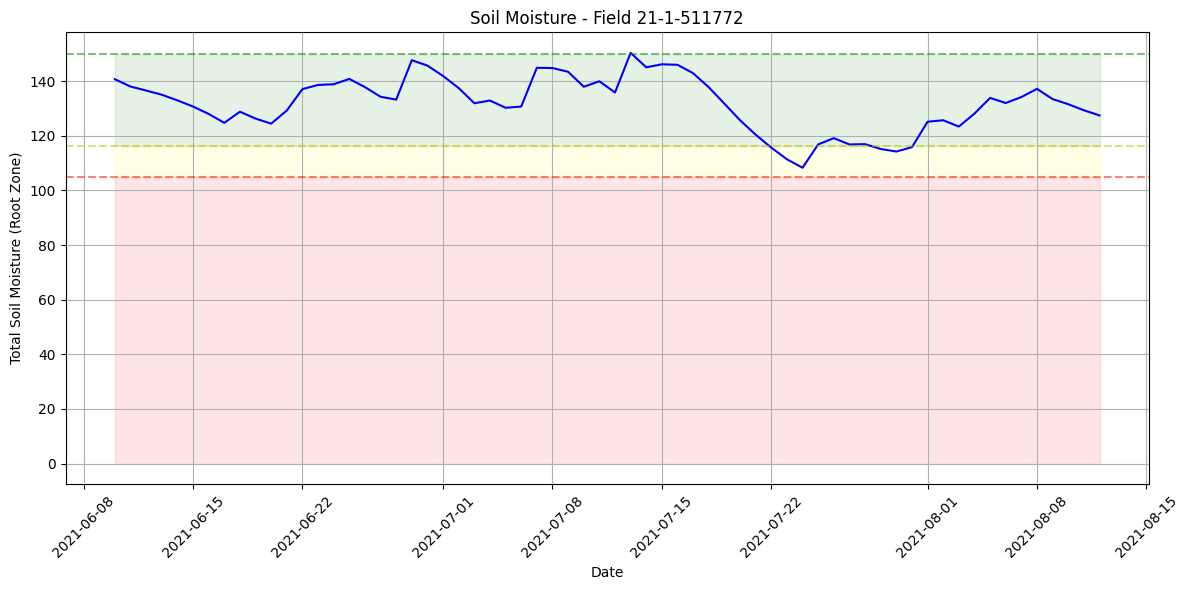

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


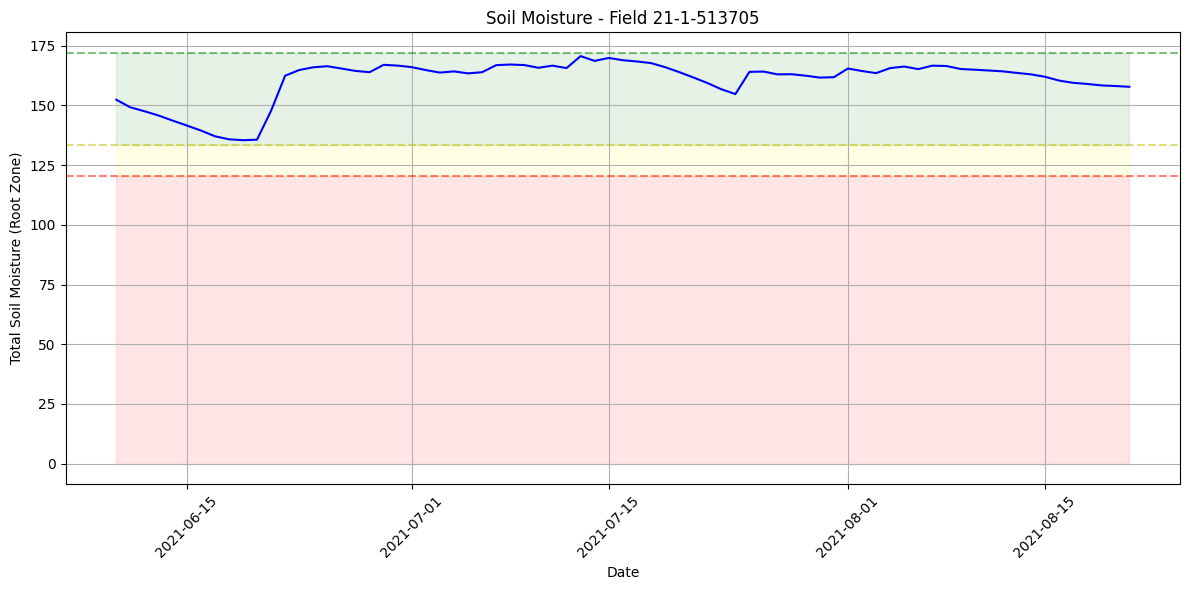

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


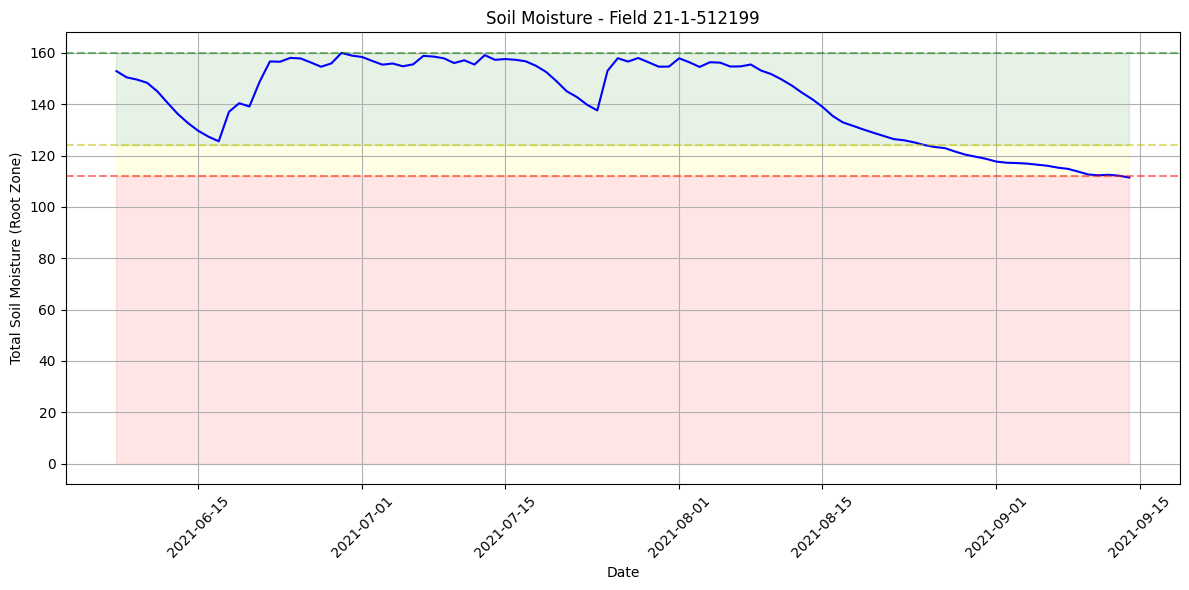

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


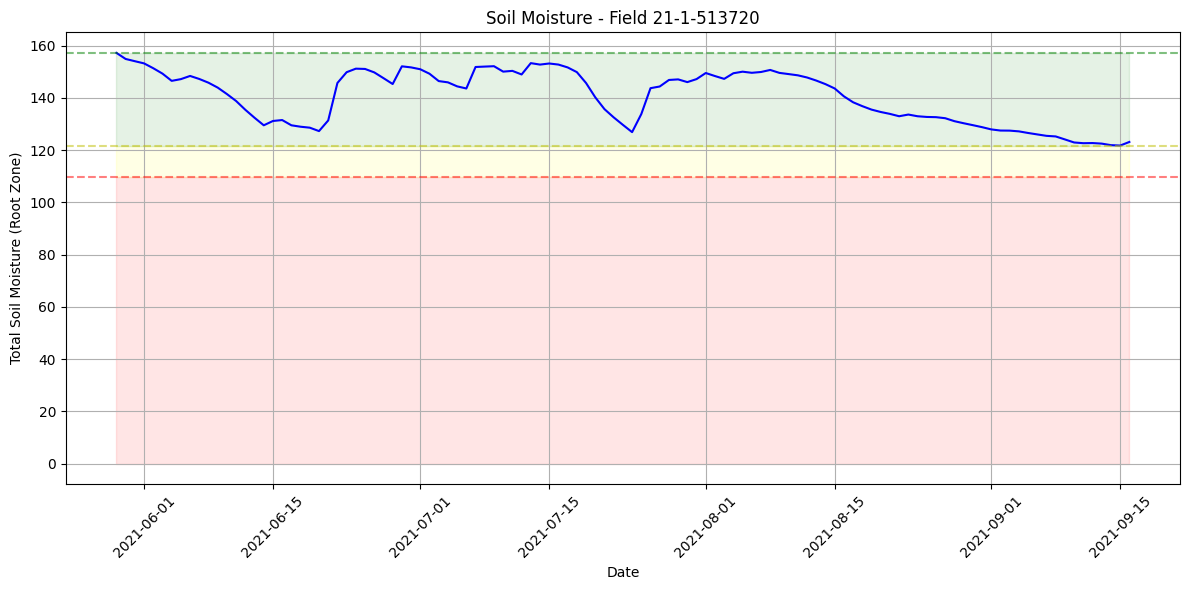

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


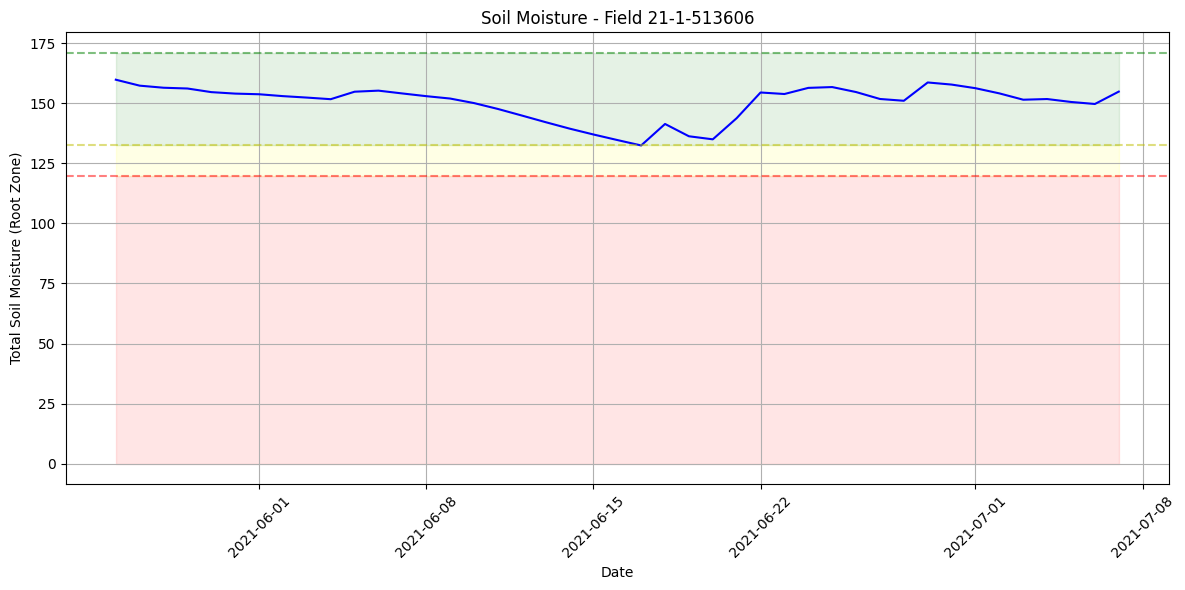

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


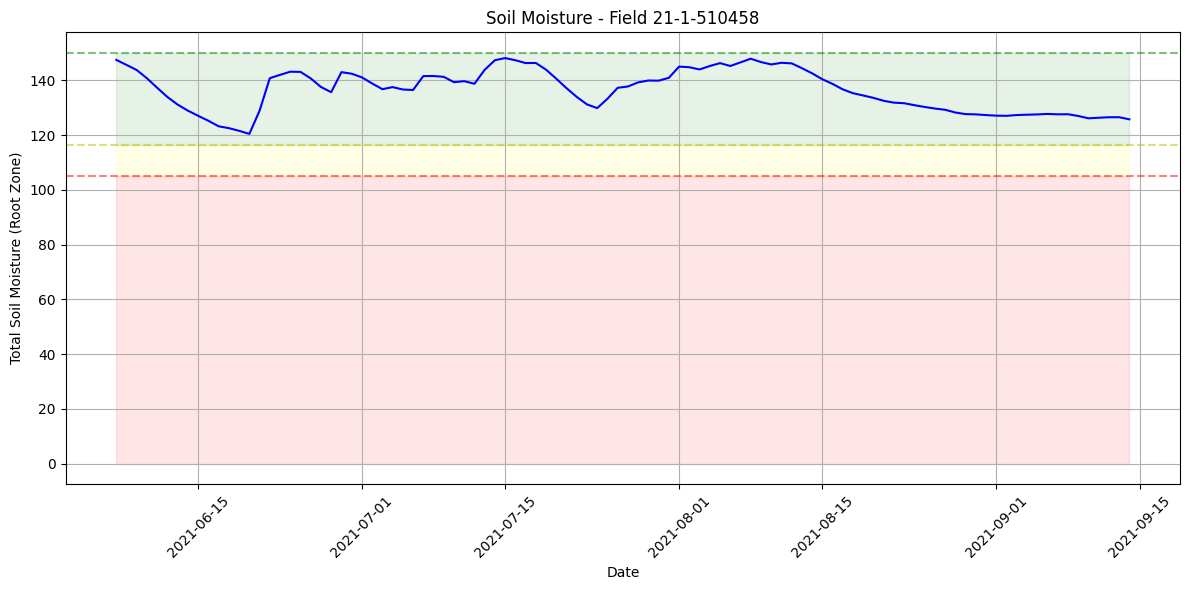

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


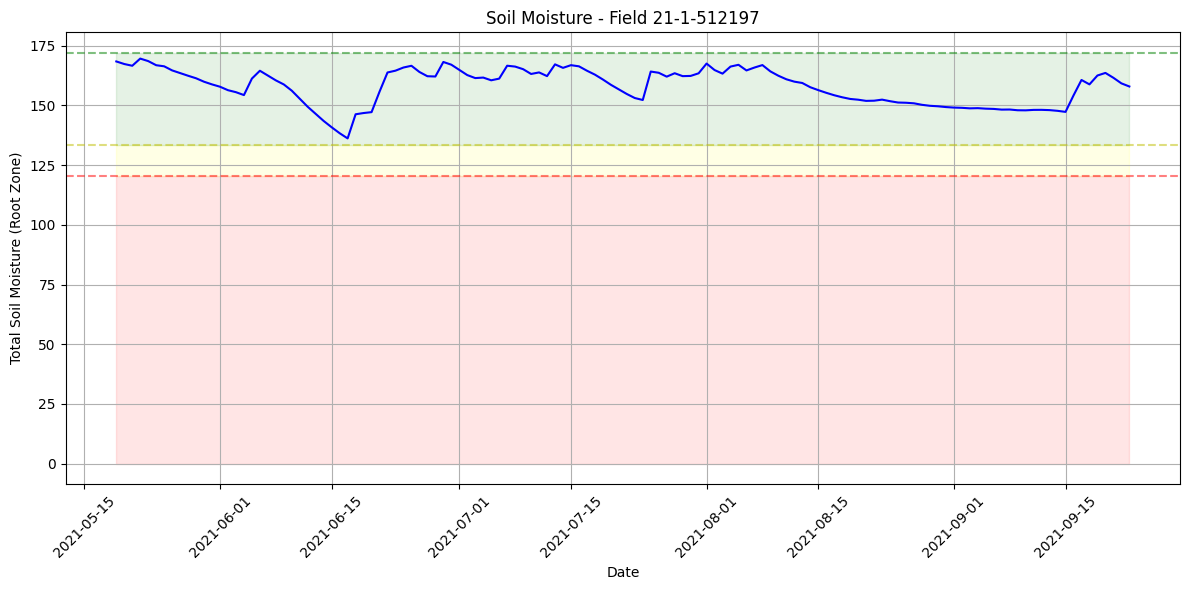

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


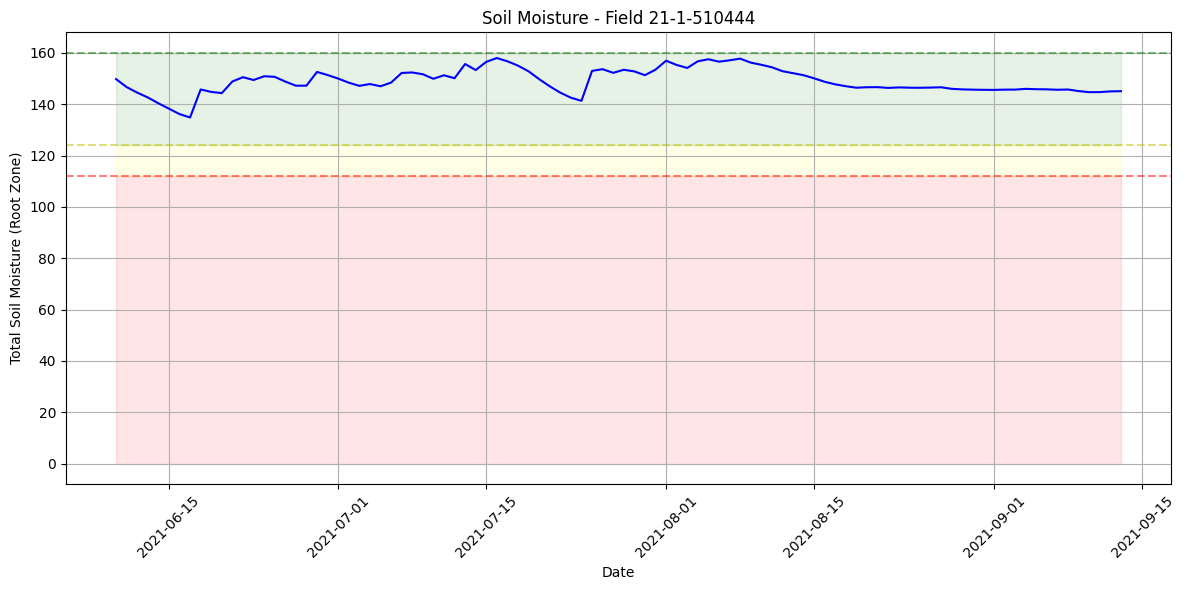

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


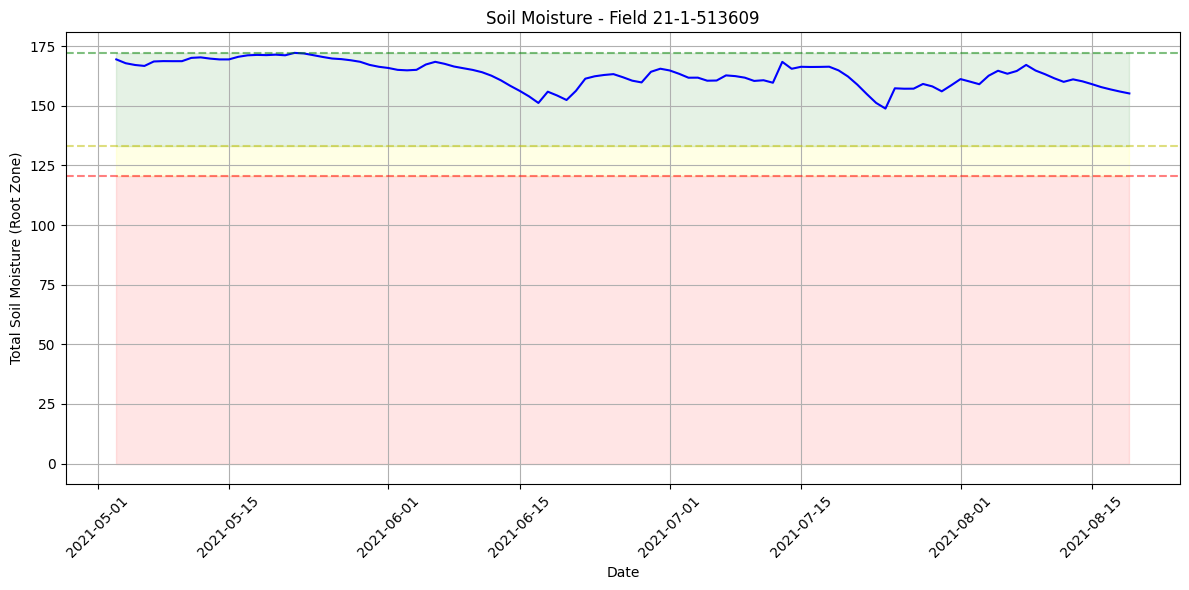

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


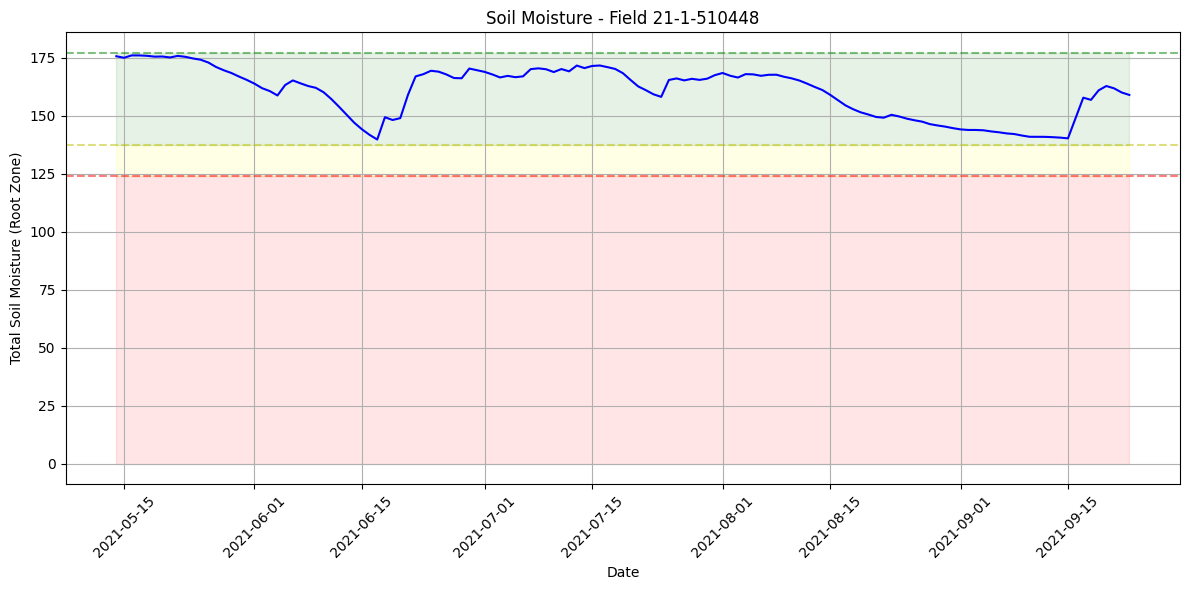

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


Error plotting field 21-1-861487


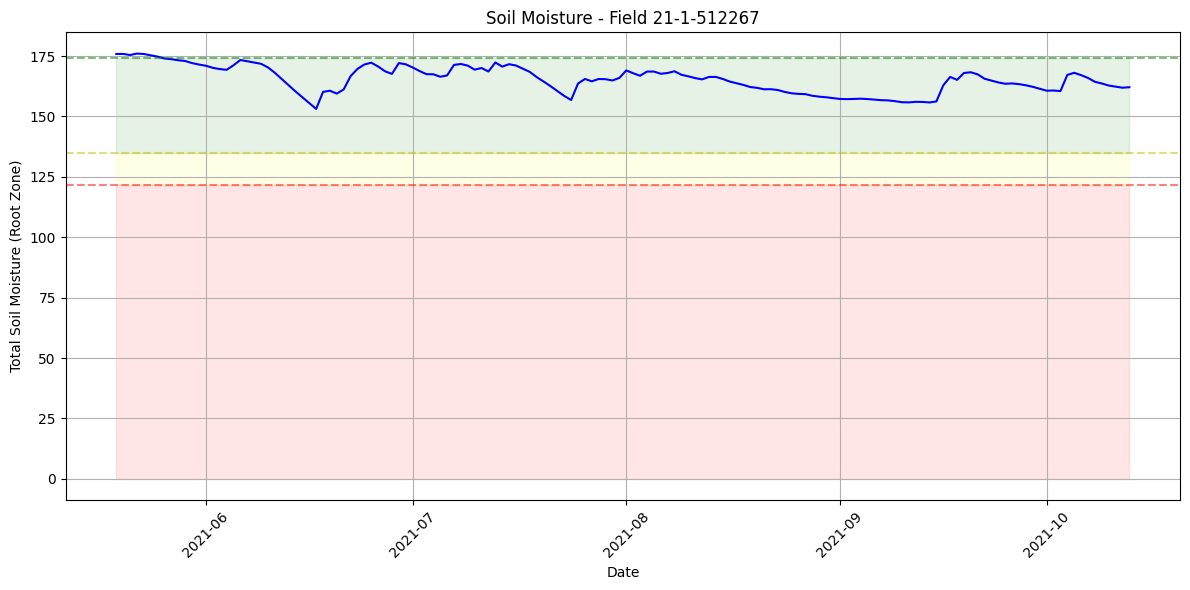

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


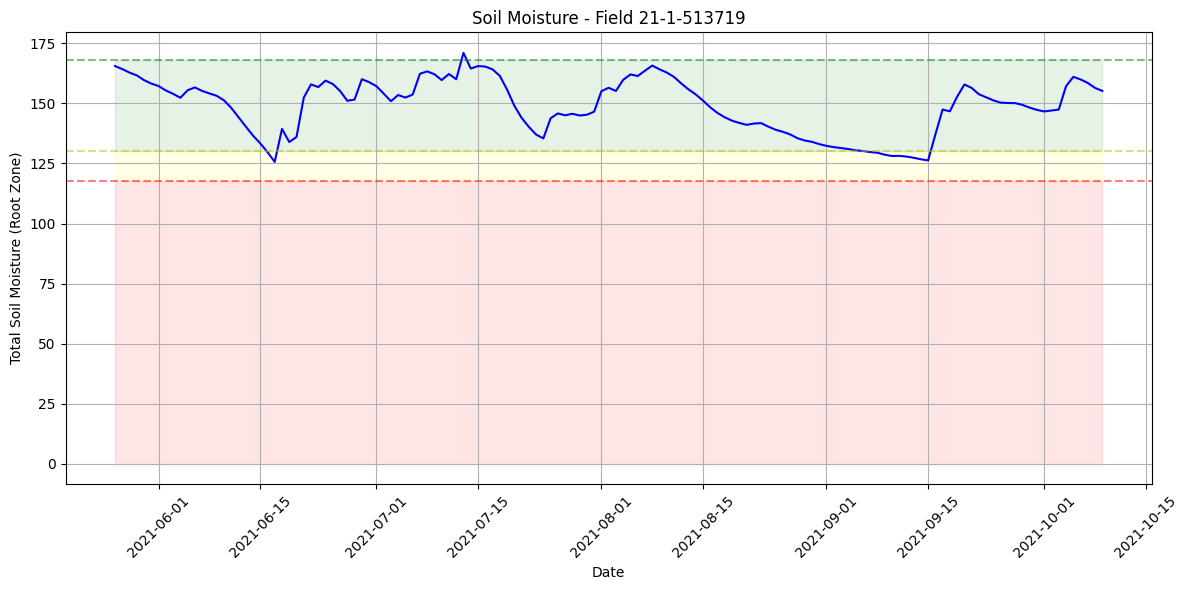

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")


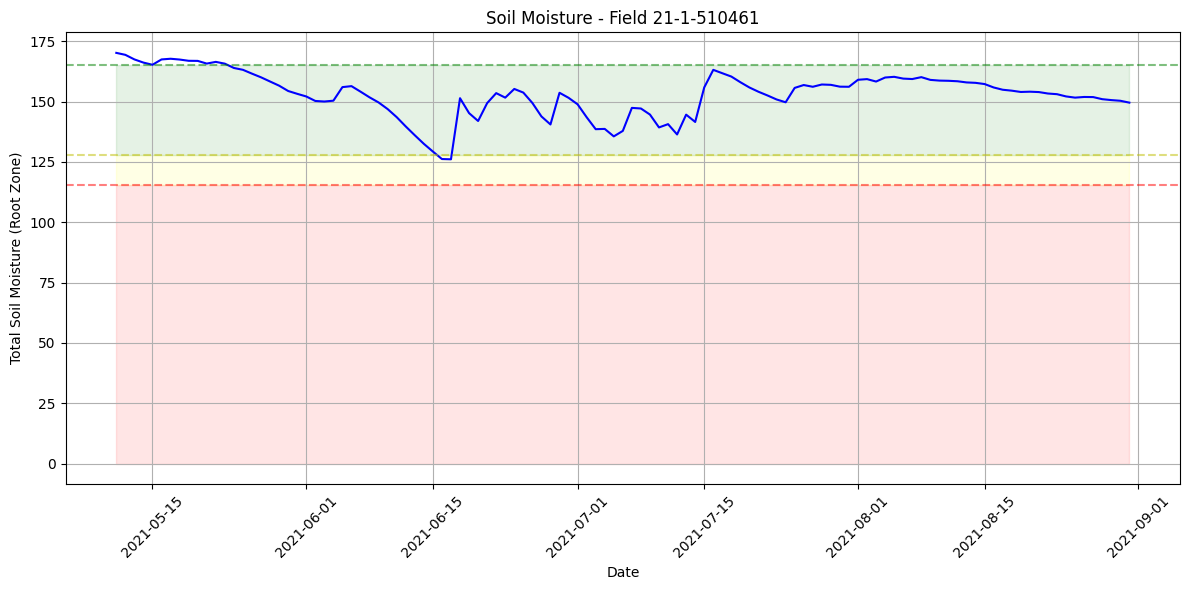

In [12]:
def plot_soil_moisture(soil_df, thresholds_df, field_id):
    # Filter data for specific field
    field_soil = soil_df[soil_df["ID"] == field_id]
    field_thresholds = thresholds_df[thresholds_df["ID"] == field_id].iloc[0]

    # Convert irrigation dates to datetime
    field_soil["Date"] = pd.to_datetime(field_soil["Date"], format="%d.%m.%Y")

    # Calculate thresholds
    fc = field_thresholds["FieldCapacity"]
    stress_threshold = field_thresholds["IrrigationThreshold"]  # 70% of FC
    warning_threshold = fc * 0.775  # 77.5% of FC

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot stress zones
    ax.fill_between(field_soil["Date"], 0, stress_threshold, color="red", alpha=0.1)
    ax.fill_between(
        field_soil["Date"],
        stress_threshold,
        warning_threshold,
        color="yellow",
        alpha=0.1,
    )
    ax.fill_between(field_soil["Date"], warning_threshold, fc, color="green", alpha=0.1)

    # Plot soil moisture
    ax.plot(field_soil["Date"], field_soil["TotalSoilMoisture_RootZone"], "b-")

    # Add threshold lines
    ax.axhline(y=stress_threshold, color="r", linestyle="--", alpha=0.5)
    ax.axhline(y=warning_threshold, color="y", linestyle="--", alpha=0.5)
    ax.axhline(y=fc, color="g", linestyle="--", alpha=0.5)

    # Customize plot
    ax.set_xlabel("Date")
    ax.set_ylabel("Total Soil Moisture (Root Zone)")
    plt.title(f"Soil Moisture - Field {field_id}")
    ax.grid(True)
    plt.xticks(rotation=45)

    plt.tight_layout()
    return plt


def plot_soil_moisture_and_irrigation(soil_df, irrigation_df, thresholds_df, field_id):
    # Filter data for specific field
    field_soil = soil_df[soil_df["ID"] == field_id]
    field_irrigation = irrigation_df[irrigation_df["ID"] == field_id]
    field_thresholds = thresholds_df[thresholds_df["ID"] == field_id].iloc[0]

    # Convert irrigation dates to datetime
    field_irrigation["Date"] = pd.to_datetime(
        field_irrigation["Date"], format="%d.%m.%Y"
    )

    # Calculate thresholds
    fc = field_thresholds["FieldCapacity"]
    stress_threshold = field_thresholds["IrrigationThreshold"]  # 70% of FC
    warning_threshold = fc * 0.775  # 77.5% of FC

    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    # Plot stress zones
    ax1.fill_between(field_soil["Date"], 0, stress_threshold, color="red", alpha=0.1)
    ax1.fill_between(
        field_soil["Date"],
        stress_threshold,
        warning_threshold,
        color="yellow",
        alpha=0.1,
    )
    ax1.fill_between(
        field_soil["Date"], warning_threshold, fc, color="green", alpha=0.1
    )

    # Plot soil moisture
    ax1.plot(field_soil["Date"], field_soil["TotalSoilMoisture_RootZone"], "b-")

    # Plot irrigation events as bars
    ax2.bar(
        field_irrigation["Date"],
        field_irrigation["Irrigation_[mm]"],
        color="lightblue",
        alpha=0.5,
        width=1,
    )

    # Add threshold lines
    ax1.axhline(y=stress_threshold, color="r", linestyle="--", alpha=0.5)
    ax1.axhline(y=warning_threshold, color="y", linestyle="--", alpha=0.5)
    ax1.axhline(y=fc, color="g", linestyle="--", alpha=0.5)

    # Customize plot
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Total Soil Moisture (Root Zone)", color="b")
    ax2.set_ylabel("Irrigation (mm)", color="lightblue")

    plt.title(f"Soil Moisture and Irrigation Events - Field {field_id}")
    ax1.grid(True)
    plt.xticks(rotation=45)

    plt.tight_layout()
    return plt


non_irrigated_soil_moisture_data = filter_df_by_ids(soil_moisture_data, non_irrigated_fields_ids)
non_irrigated_irrigation_threshold_data = filter_df_by_ids(irrigation_threshold_data, non_irrigated_fields_ids)

irrigated_soil_moisture_data = filter_df_by_ids(soil_moisture_data, irrigated_fields_ids)
irrigated_irrigation_threshold_data = filter_df_by_ids(irrigation_threshold_data, irrigated_fields_ids)

for field_id in non_irrigated_fields_ids:
    # plot_soil_moisture_and_irrigation(
    #     soil_moisture_data, validation_irrigation, irrigation_threshold_data, field_id
    # )
    try:
        plot_soil_moisture(
            non_irrigated_soil_moisture_data, non_irrigated_irrigation_threshold_data, field_id
        )
        plt.show()
    except:
        print(f"Error plotting field {field_id}")
        continue

### Finding stress irrigated fields

In [13]:
def find_stress_irrigated_fields(
    soil_df: pd.DataFrame,
    irrigation_df: pd.DataFrame,
    thresholds_df: pd.DataFrame,
    buffer_days: int = 3,
) -> List[str]:

    stress_irrigated = []

    for field_id in thresholds_df["ID"].unique():
        # Get data for this field
        field_soil = soil_df[soil_df["ID"] == field_id]
        field_irrigation = irrigation_df[irrigation_df["ID"] == field_id].copy()
        threshold = thresholds_df[thresholds_df["ID"] == field_id][
            "IrrigationThreshold"
        ].iloc[0]

        # Convert dates
        field_irrigation["Date"] = pd.to_datetime(
            field_irrigation["Date"], format="%d.%m.%Y"
        )

        # Find dates where moisture dropped below threshold
        stress_dates = field_soil[field_soil["TotalSoilMoisture_RootZone"] < threshold][
            "Date"
        ]

        # Check each stress date
        for stress_date in stress_dates:
            # Look for irrigation within next 3 days
            irrigation_window = field_irrigation[
                (field_irrigation["Date"] >= stress_date)
                & (
                    field_irrigation["Date"]
                    <= stress_date + pd.Timedelta(days=buffer_days)
                )
            ]

            if not irrigation_window.empty:
                stress_irrigated.append(field_id)
                break

    return list(set(stress_irrigated))

stress_irrigated_fields = find_stress_irrigated_fields(
    irrigated_soil_moisture_data, validation_irrigation, irrigated_irrigation_threshold_data
)

stress_irrigated_fields

['19-1-510429', '18-1-510465', '19-1-510467', '19-1-859059', '19-1-510458']

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_irrigation["Date"] = pd.to_datetime(


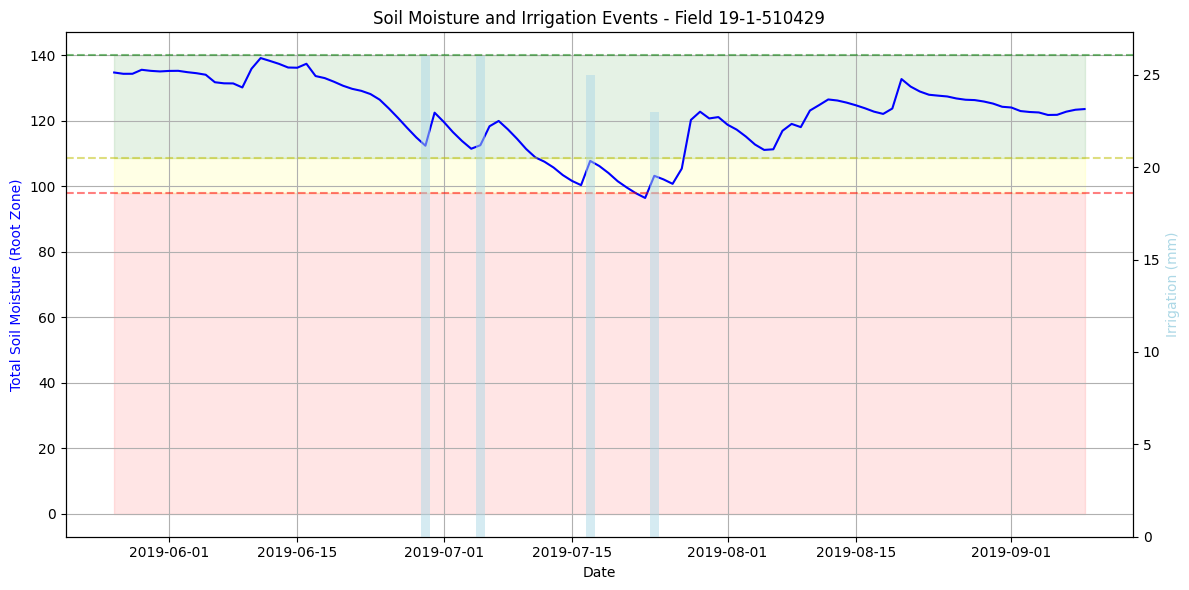

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_irrigation["Date"] = pd.to_datetime(


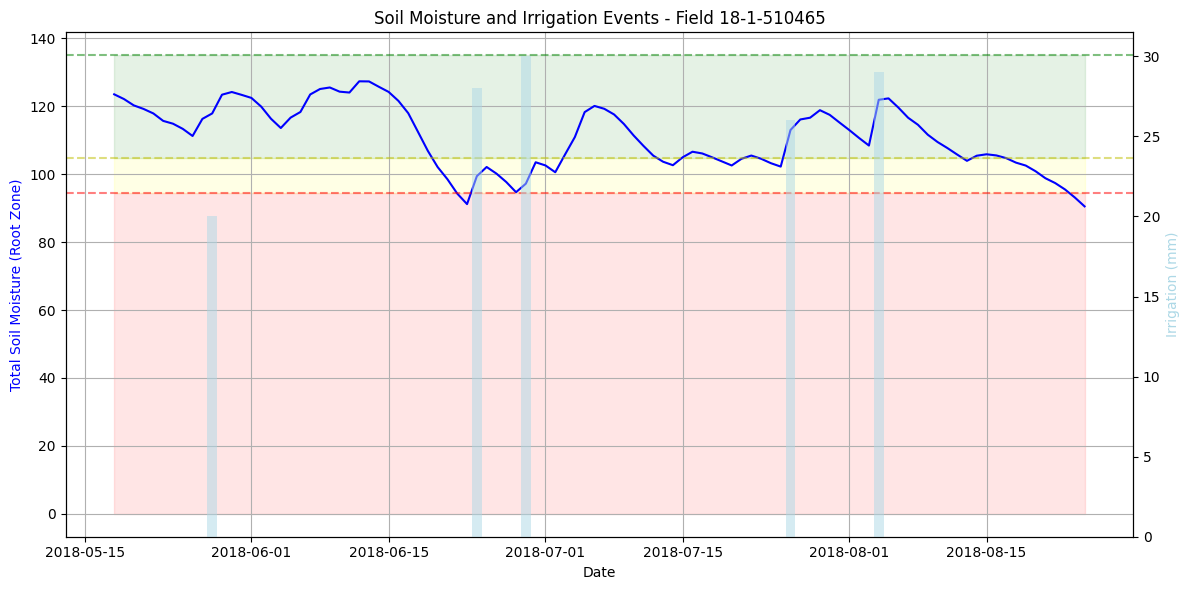

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_irrigation["Date"] = pd.to_datetime(


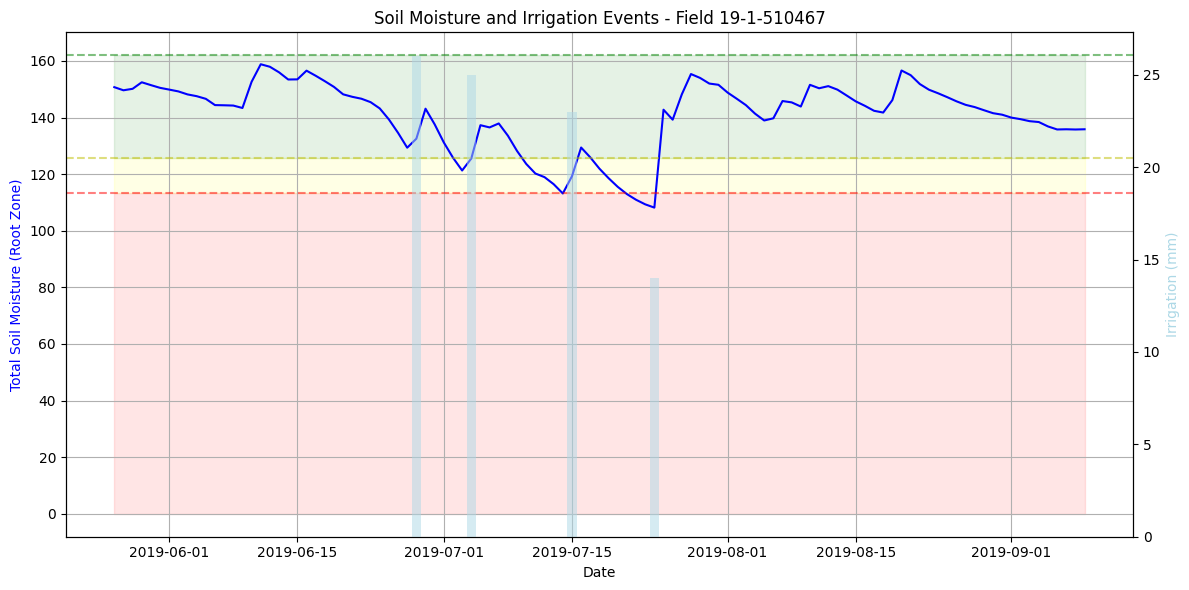

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_irrigation["Date"] = pd.to_datetime(


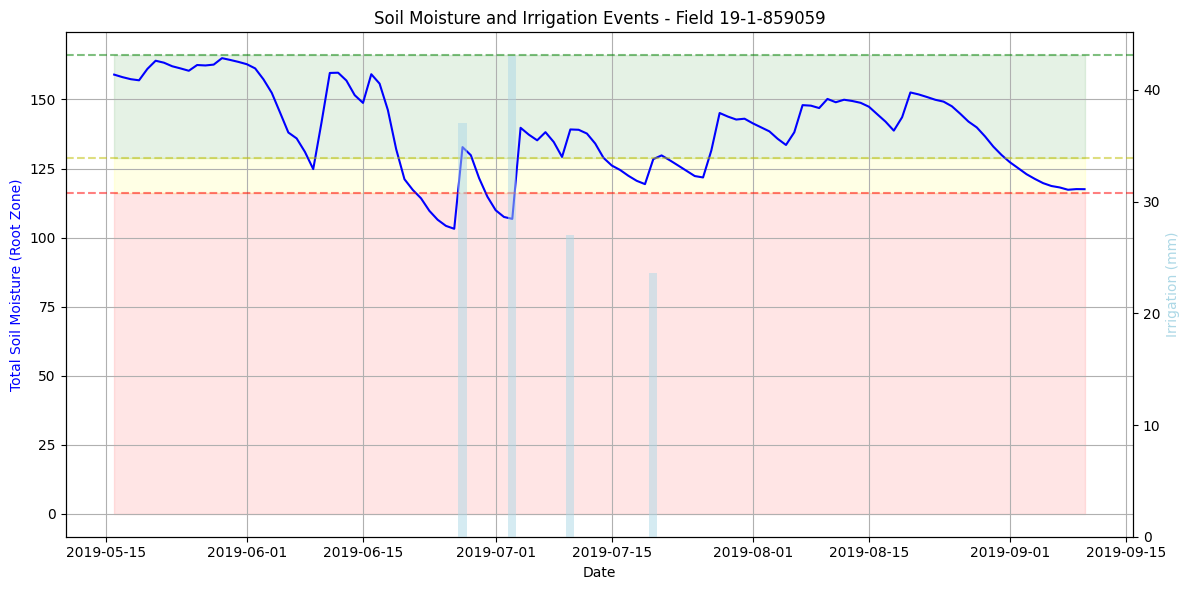

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_607/3029165088.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_irrigation["Date"] = pd.to_datetime(


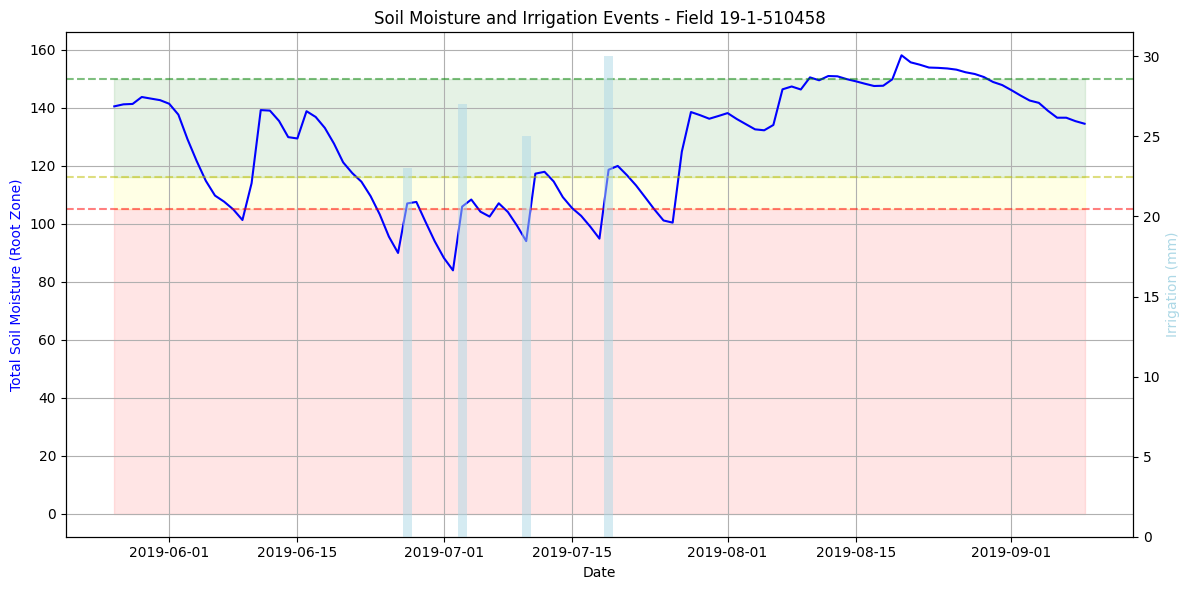

In [14]:
for field_id in stress_irrigated_fields:
    plot_soil_moisture_and_irrigation(
        soil_moisture_data, validation_irrigation, irrigation_threshold_data, field_id
    )
    plt.show()

### Comparing to Sofias "Wasserstress Einschätzung"

In [15]:
stress_estimation_path = "/Users/cooper/Desktop/irrigation-mapper/data/SoilMoistureData/DataIrrigation_Analyse_hsol.csv"

stress_estimation = pd.read_csv(stress_estimation_path, sep=";", encoding="utf-8")


def get_water_stressed_fields(stress_estimation: pd.DataFrame) -> List[str]:
    return list(
        stress_estimation[stress_estimation["Beurteilung"] == "Wasserstress"][
            "ID"
        ].unique()
    )


estimated_stress_fields = get_water_stressed_fields(stress_estimation)

# Check if two list contain the same elements
set(stress_irrigated_fields) == set(estimated_stress_fields)

True

## Checking if ET blue maps pick up the fields that are irrigated in water stress

In [16]:
def get_et_blue_sum_image(date: List[str], product: str) -> ee.ImageCollection:
    path = f"projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_postprocessed/ET_blue_postprocessed_dekadal_from_{product}_v2"

    if len(date) == 1:
        start_date = pd.to_datetime(date) - pd.Timedelta(days=5)
        end_date = pd.to_datetime(date) + pd.Timedelta(days=5)

        # Date to ee.Date
        start_date = ee.Date(start_date.strftime("%Y-%m-%d"))
        end_date = ee.Date(end_date.strftime("%Y-%m-%d"))

    else:
        start_date = pd.to_datetime(date[0])
        end_date = pd.to_datetime(date[1])

        # Date to ee.Date
        start_date = ee.Date(start_date.strftime("%Y-%m-%d"))
        end_date = ee.Date(end_date.strftime("%Y-%m-%d"))

    et_blue_image = (
        ee.ImageCollection(path)
        .filterDate(start_date, end_date)
        .map(lambda img: back_to_float(img, 100))
        .select("ET_blue")
        .sum()
        .rename("ET_blue_sum")
    )

    return ee.Image(et_blue_image)


date = ["2019-05-01", "2019-10-01"]
product = "WaPOR_10m"

et_blue_image = get_et_blue_sum_image(date, product)

type(et_blue_image)

ee.image.Image

In [19]:
fields_to_check = ["19-1-510429", "19-1-510458", "19-1-859059", "19-1-510467"]

fields = get_fields_by_id(field_dict[2019], fields_to_check)

fields

In [21]:
Map = geemap.Map(height="800px")

vis_params = {
    "min": 0,
    "max": 10,
    "palette": ["white", "blue"],
}

geom = fields.geometry()
Map.centerObject(geom, 12)
Map.addLayer(et_blue_image, vis_params, "ET Blue")
Map.addLayer(fields, {}, "Fields")

Map


Map(center=[46.82821487884409, 6.918664270303157], controls=(WidgetControl(options=['position', 'transparent_b…